# Mini-projet n°1 – Chats ou Chiens ?

In [13]:
# Import des librairies nécéssaires

# le fichier Chat_ou_Chiens_lib.py contient toutes les fonctions et réseaux utilisé.e.s dans ce notebook. Le code est commenté dans le fichier pour plus de détails.

from Chat_ou_Chiens_lib import *
import importlib

In [53]:
# Bout de code pour recharger la librairie après modification
import Chat_ou_Chiens_lib
importlib.reload(Chat_ou_Chiens_lib)
from Chat_ou_Chiens_lib import *

## 1- Analyse exploratoire du jeu de données

### A- Étudier la répartition par race et par type (chat/chien)

Le jeu de données est composé de 7349 lignes.
Chaque ligne a :
- un type : chat ou chien
- une race : 37 races différentes

On commence par créer un dataframe propre.

In [15]:
df = pd.read_csv(# Lecture du fichier list.txt
    "./oxford-iiit-pet/annotations/list.txt",
    sep=r"\s+",                                         # séparateur = espaces multiples
    comment="#",                                        # ignorer les lignes commençant par #
    header=None,                                        # pas d'en-tête dans les lignes de données
    names=["Image", "CLASS_ID", "SPECIES", "BREED_ID"]  # noms des colonnes
)

# On rajoute des colonnes pour mieux labelliser les données
df["BREED_NAME"] = df["Image"].str.rsplit("_", n=1).str[0]     # Nom de la race
df["SPECIES_NAME"] = df["SPECIES"].map({1: "Cat", 2: "Dog"})   # Chat ou chien
df["Image"] = df["Image"].apply(lambda x: f"{x}.jpg")          # Ajout du chemin complet vers chaque image. Il faut faire attention car les images ne sont pas dans "annotations" mais dans le dossier "images"
print(df.head())

                Image  CLASS_ID  SPECIES  BREED_ID  BREED_NAME SPECIES_NAME
0  Abyssinian_100.jpg         1        1         1  Abyssinian          Cat
1  Abyssinian_101.jpg         1        1         1  Abyssinian          Cat
2  Abyssinian_102.jpg         1        1         1  Abyssinian          Cat
3  Abyssinian_103.jpg         1        1         1  Abyssinian          Cat
4  Abyssinian_104.jpg         1        1         1  Abyssinian          Cat


On peut visualiser le nombre de chiens et de chats :

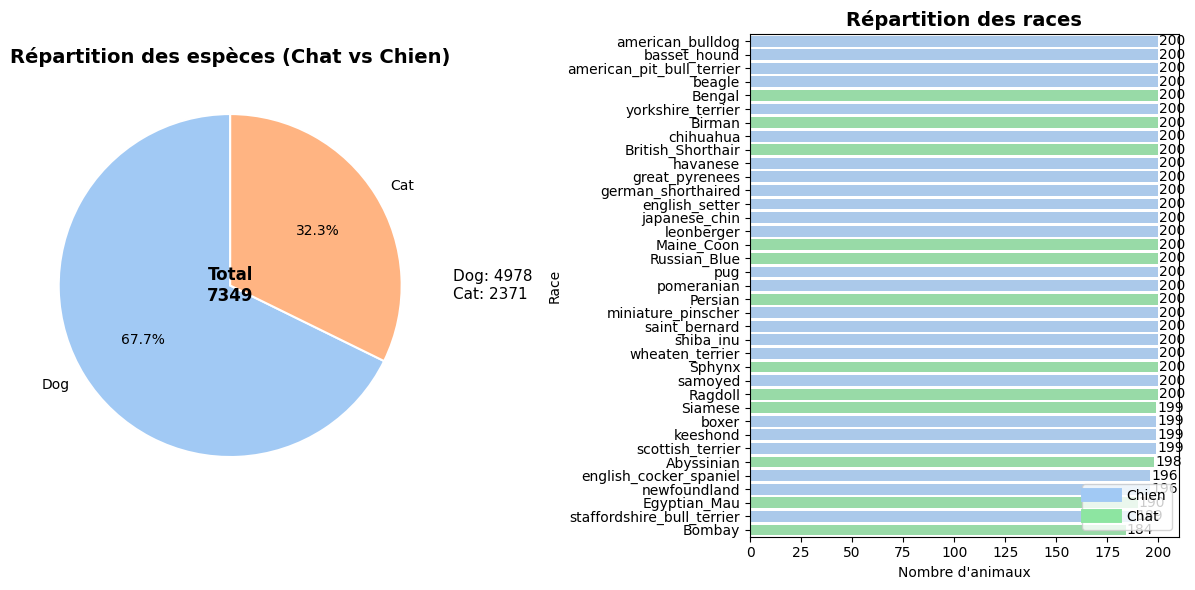

In [5]:
counts_species = df["SPECIES_NAME"].value_counts()
counts_breed = df["BREED_NAME"].value_counts()

species_per_breed = df.drop_duplicates("BREED_NAME").set_index("BREED_NAME")["SPECIES_NAME"] #j'ai voulu faire en sorte d'harmoniser les couleurs entre les deux graphiques mais je n'y arrive pas :'(
colors = {"Dog": sns.color_palette("pastel")[0],"Cat": sns.color_palette("pastel")[2]}
palette = [colors[species_per_breed[breed]] for breed in counts_breed.index]

fig, axes = plt.subplots(1, 2, figsize=(12, 6))

# Premier graphique : espèces
colors_species = sns.color_palette("pastel", len(counts_species))
axes[0].pie(counts_species,labels=counts_species.index,autopct="%1.1f%%",startangle=90,colors=colors_species,wedgeprops={"edgecolor": "white", "linewidth": 1.5}) 
axes[0].set_title("Répartition des espèces (Chat vs Chien)", fontsize=14, fontweight="bold")
total = counts_species.sum()
axes[0].text(0, 0, f"Total\n{total}", ha='center', va='center', fontsize=12, fontweight='bold')
species_counts_text = "\n".join([f"{k}: {v}" for k, v in counts_species.items()]) # Ajouter le nombre exact de chaque espèce en légende
axes[0].text(1.3, 0, species_counts_text, fontsize=11, va='center')

# Deuxième graphique : races
sns.barplot(y=counts_breed.index,x=counts_breed.values,hue=counts_breed.index,palette=palette,legend=False,ax=axes[1])
axes[1].set_title("Répartition des races", fontsize=14, fontweight="bold")
axes[1].set_xlabel("Nombre d'animaux")
axes[1].set_ylabel("Race")
for i, v in enumerate(counts_breed.values):
    axes[1].text(v + 0.5, i, str(v), va='center', fontsize=10)

axes[1].legend(handles=[plt.Line2D([0], [0], color=colors["Dog"], lw=10, label="Chien"),plt.Line2D([0], [0], color=colors["Cat"], lw=10, label="Chat")],loc="lower right") #légendes chien chat en bas à droite 
plt.tight_layout()
plt.show()

on voit clairement que les deux tiers des données sont des chiens, et le tier restant est composé de chats.  
Il y a environ 200 individus de chacune des races.
On remarque aussi qu'il y a 25 races de chiens et seulement 12 de chats.

### B- Vérifier la cohérence et la qualité des masques de segmentation

Les masques de ségmentation se trouvent dans le dossier *oxford-iiit-pet/annotations/trimaps*.
Chaque image du jeu de données possède un masque associé qui délimite les pixels selon trois classes :
- 1 = Foreground (le corps de l'animal)
- 2 = Background (le fond de l'image)
- 3 = Not classified (on sait pas ce que sait)

Pour vérifier la cohérence et la qualité des masques, on va regarder à la main un petit échantillons, en affichant côte à côte les images et le masque associé.

In [16]:
indices = np.random.choice(df.index, size=5, replace=False) # on choisit les indices des images que l'on va visualiser au hasard
 
img_dir = "oxford-iiit-pet/images/"                 # Chemin du répertoire qui contient les images
mask_dir = "oxford-iiit-pet/annotations/trimaps/"   # Chemin du répertoire qui contient les masques
masks = [f for f in os.listdir(mask_dir) if f.endswith(".png") and not f.startswith("._")] # On ignore les fichiers bizarres qui commencent par "._" qui sont dans le repertoire 

nom de l'image : scottish_terrier_58


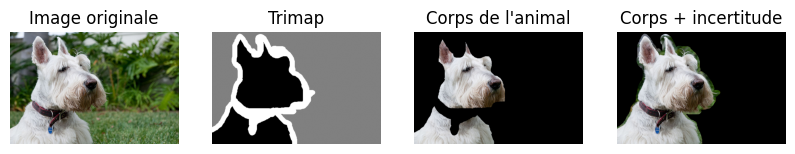

nom de l'image : miniature_pinscher_4


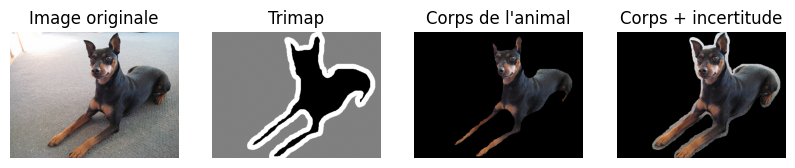

nom de l'image : american_pit_bull_terrier_105


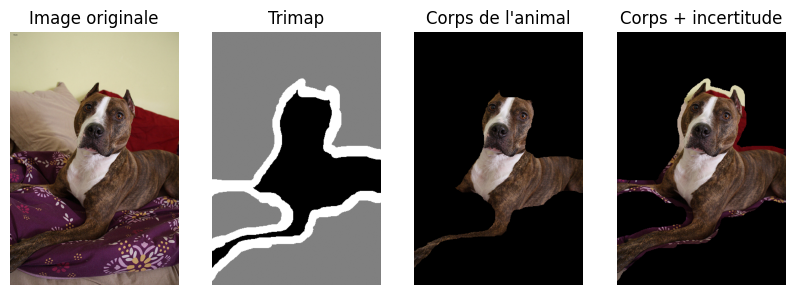

nom de l'image : Sphynx_239


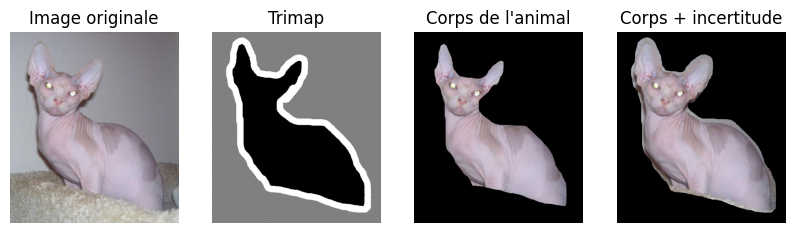

nom de l'image : Siamese_136


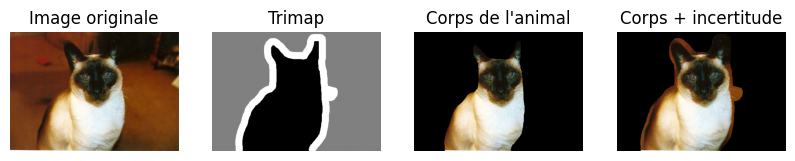

In [6]:
for indice in indices:
    image = masks[indice]
    name = os.path.splitext(image)[0]
    print("nom de l'image :",name)

    img_path = os.path.join(img_dir, name + ".jpg") # On récupère le path de l'image
    mask_path = os.path.join(mask_dir, image)       # On récupère le path du masque

    img = np.array(Image.open(img_path))            # On récupère les valeurs des pixels dans des np.array 
    mask = np.array(Image.open(mask_path))          # (on utilise la librairie PIL pour faire cela)

    #On visualise les pixels qui composent le corps de l'animal selon le masque (1) 
    masked_img_moins= img.copy()
    masked_img_moins[mask != 1] = 0   # on garde seulement les pixels 1, on met tout le reste à 0 (en noir)

    #On visualise les pixels qui composent le corps de l'animal selon le masque (1) et la zone d'incertitude (2)
    masked_img_plus= img.copy()
    masked_img_plus[mask == 2] = 0   # on garde seulement les pixels 1 et 3, on met les pixel 2 à 0 (en noir)

    plt.figure(figsize=(10,5))
    #On affiche nos 4 images
    plt.subplot(1,4,1)
    plt.imshow(img)
    plt.title("Image originale")
    plt.axis("off")

    plt.subplot(1,4,2)
    plt.imshow(mask, cmap="gray")
    plt.title("Trimap")
    plt.axis("off")

    plt.subplot(1,4,3)
    plt.imshow(masked_img_moins)
    plt.title("Corps de l'animal")
    plt.axis("off")

    plt.subplot(1,4,4)
    plt.imshow(masked_img_plus)
    plt.title("Corps + incertitude")
    plt.axis("off")

    plt.show()

En parcourant à la main les images, les masques semblent cohérents et de plutot bonne qualité.
Il peut y avoir des confusions lorsque l'animal porte un colier par exemple (indice 4321) mais dans l'ensemble on obtient ce qu'on attend du masque.

### C- Identifier d’éventuels déséquilibres ou biais visuels

Comme vu précedement, le dataset n'est pas équilibré entre les chats (1/3 des individus et 12 races) et les chiens (2/3 des individus et 25 races).  
On peut aussi regarder le contenu des images, en particulier l'arrière plan.

In [7]:
#Fonction pour afficher un échantillon d'une race
def show_breed_samples(df, breed, n=5, img_dir="./oxford-iiit-pet/images/"):
    samples = df[df['BREED_NAME'] == breed]
    
    # Sécurité au cas où on demande plus d'images qu'il n'en existe
    n = min(n, len(samples))
    samples = samples.sample(n)
    
    plt.figure(figsize=(15, 5))
    for i, (idx, row) in enumerate(samples.iterrows()):
        img_path = os.path.join(img_dir, row['Image'])
        
        try:
            img = Image.open(img_path)
            plt.subplot(1, n, i + 1)
            plt.imshow(img)
            plt.axis("off")
        except Exception as e:
            print(f"Erreur sur l'image {img_path}: {e}")
            
    plt.tight_layout()
    plt.show()

Par exemple on remarque que beaucoup de photos de bulldog américains ont été prises en extérieur, tandis que pour les chats "Abyssian", ils sont beaucoup en intérieur. Cela peut impliquer que le modèle n'apprend pas à détecter des bulldogs mais qu'il apprend à détecter de l'herbe.

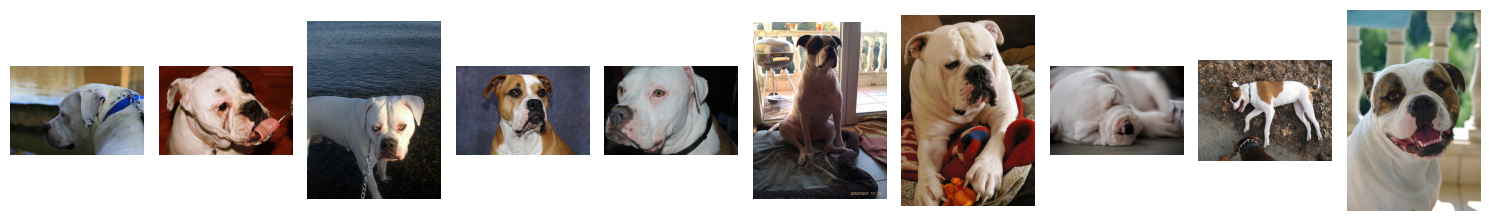

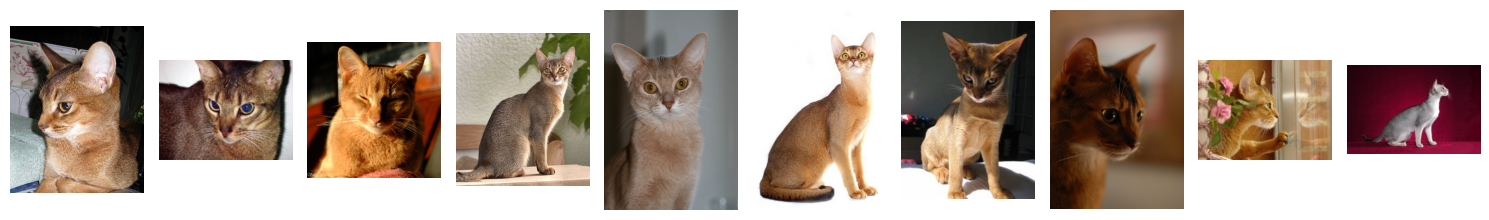

In [8]:
show_breed_samples(df, 'american_bulldog', n=10)
show_breed_samples(df, 'Abyssinian', n=10)

On pourrait aussi regarder si la luminosité est la même pour toutes les photos, ou bien si le cadrage est le même, mais cela prend du temps, nous préférons le consacrer à la suite.

## 2- Classification Binaire

Nous cherchons à distinguer les chats des chiens à partir de leurs photos uniquement.
Pour cela, nous allons mettre en place plusieurs approches, en suivant la méthodologie vue en TP.

Un réseau de neurones convolutionnel (CNN) est particulièrement adapté pour la classification d’images, car il est capable d’apprendre automatiquement des caractéristiques visuelles comme les contours, textures ou motifs propres à chaque classe (ici chats et chiens).
Concrètement, dans ce notebook, nous proposerons trois réseaux de neurones pour réaliser cette tâche de classification :

- un CNN "naïf",
- un CNN entraîné sur un jeu de données augmenté,
- et un réseau utilisant le concept de “Transfer Learning”.

Pour ce dernier, nous utiliserons directement le jeu de données augmenté, puis nous effectuerons une phase de “Fine Tuning” afin d’en améliorer encore les performances.

Nous utiliserons TensorFlow par la suite.

### Gestion des données d'entrée
Les réseaux de neurones que nous allons mettre en place nécessitent des données d’entrée de taille fixe. Nous commencerons donc par vérifier et contrôler la taille de nos images.

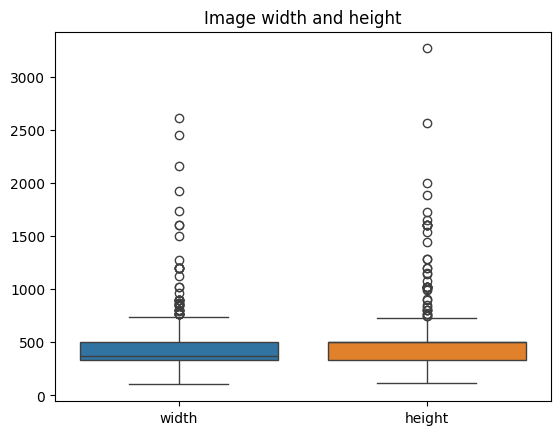

In [9]:
img_size = np.zeros((df.shape[0],2))
for i, image in enumerate(df['Image']) :
    img = img_to_array( load_img(img_dir + image) )
    img_size[i,:] = img.shape[:2]

plt.figure()
ax = sns.boxplot(img_size)
ax.set_xticks(ax.get_xticks())
ax.set_xticklabels(['width', 'height'])
plt.title("Image width and height")
plt.show()

On constate que toutes les images n’ont pas les mêmes dimensions.
Nous allons donc devoir les redimensionner, en imposant une taille uniforme de 150 × 150 pixels.
(Il est possible de choisir une taille plus grande, 400 ou 500 par exemple, mais cela entraînerait des coûts de calcul plus élevés.)

Nous avons maintenant un choix à faire : soit redimensionner toutes les images avant de les séparer en ensembles d’entraînement, de validation et de test, soit séparer d’abord les ensembles puis redimensionner les images.
Pour rester cohérents avec la méthodologie vue en TP, nous choisissons la deuxième approche.

- On sépare en données d'entrainement, de validation et de test :

In [17]:
# On part du DataFrame complet : df qui a comme colonnes : mage, CLASS_ID, SPECIES, BREED_ID, BREED_NAME, SPECIES_NAME
data = df[["Image", "SPECIES_NAME"]].copy() # On crée d’abord une version simplifiée pour la séparation

N_train = 5200          # environ 70% de l'ensemble des données
N_Validation = 1000  
temp_df, train_df = train_test_split(data, test_size=N_train, stratify=data["SPECIES_NAME"])                    # On prend 5000
test_df, validation_df = train_test_split(temp_df, test_size=N_Validation, stratify=temp_df["SPECIES_NAME"])    # On prend 1000  dans ce qu'il reste N_test = N_total - (N_train+N_validation)

print("Train set :", train_df.shape)
print("Validation set :", validation_df.shape)
print("Test set :", test_df.shape)
print("\n----Répartition des catégories----\n")
print("Train :", train_df["SPECIES_NAME"].value_counts())
print("\nValidation :", validation_df["SPECIES_NAME"].value_counts())
print("\nTest :", test_df["SPECIES_NAME"].value_counts())

Train set : (5200, 2)
Validation set : (1000, 2)
Test set : (1149, 2)

----Répartition des catégories----

Train : SPECIES_NAME
Dog    3522
Cat    1678
Name: count, dtype: int64

Validation : SPECIES_NAME
Dog    678
Cat    322
Name: count, dtype: int64

Test : SPECIES_NAME
Dog    778
Cat    371
Name: count, dtype: int64


- On redimensionne nos images : On choisit une dimension de 224 pixels par 224 pixels pour correspondre à la dimension d'entrée du réseau pré-entraîné VGG16 utilisé pour le transfer-learning plus tard.

In [18]:
batch_size = 20  # doit être un diviseur de N_train and N_validation (20 est bien un diviseur de 5200 et 1000, c'est pour ça qu'on a pris des valeurs rondes pour N_train et N_validation)
img_width = 224
img_height = 224

# Training images
train_datagen = ImageDataGenerator(rescale=1./255)
train_generator = train_datagen.flow_from_dataframe(
    train_df,
    img_dir,
    x_col = 'Image',
    y_col = 'SPECIES_NAME',
    target_size = (img_height, img_width),
    class_mode = 'binary',
    batch_size = batch_size
)

# Validation images
validation_datagen = ImageDataGenerator(rescale=1./255)
validation_generator = validation_datagen.flow_from_dataframe(
    validation_df,
    img_dir,
    x_col = 'Image',
    y_col = 'SPECIES_NAME',
    class_mode = 'binary',
    target_size = (img_height, img_width),
    batch_size = batch_size
)

# Test images
test_datagen = ImageDataGenerator(rescale=1./255)
test_generator = test_datagen.flow_from_dataframe(
    test_df,
    img_dir,
    x_col = 'Image',
    y_col = 'SPECIES_NAME',
    class_mode = 'binary',
    target_size = (img_height, img_width),
    batch_size = batch_size
)

Found 5200 validated image filenames belonging to 2 classes.
Found 1000 validated image filenames belonging to 2 classes.
Found 1149 validated image filenames belonging to 2 classes.


### A - CNN "naïf"

Le réseau que nous allons définir est un CNN “naïf”, simple, constitué de plusieurs couches convolutionnelles et de pooling, suivi de couches entièrement connectées. Voici la logique derrière sa construction :
- Couche d’**entrée** (Input) : elle prend des images de taille (img_width, img_height, 3) — 3 canaux pour les couleurs RGB.
- Couches **convolutionnelles** (Conv2D) : elles détectent progressivement des motifs de plus en plus complexes dans les images.
- Couches de **pooling** (MaxPooling2D) : elles réduisent la taille des cartes de caractéristiques tout en conservant les informations importantes, ce qui diminue le coût de calcul et évite le surapprentissage.
- Couches **denses** (Dense) : après avoir aplati les cartes de caractéristiques avec Flatten(), ces couches permettent au réseau d’apprendre des combinaisons non linéaires pour la classification finale.
- **Dropout** : cette couche de régularisation permet de réduire le risque de surapprentissage en désactivant aléatoirement certaines neurones pendant l’entraînement.
- Couche de **sortie** : une seule unité avec une activation sigmoid, adaptée à la classification binaire (chat ou chien).

Ce premier CNN est implémenté avec la fonction **cnn_simple** dans le fichier **Chat_ou_Chiens_lib.py**.

In [19]:
cnn_naif=cnn_simple("cnn_naif",img_width, img_height)
cnn_naif.summary()  # Affichage de nos couches et du nombre de paramètres

Model: "cnn_naif"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d_32 (Conv2D)              │ (None, 222, 222, 32)   │           896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 111, 111, 32)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_33 (Conv2D)              │ (None, 109, 109, 64)   │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 54, 54, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_34 (Conv2D)              │ (None, 52, 52, 96)     │        55,392 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_2 (MaxPooling2D)  │ (None, 26, 26, 96)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 64896)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_4 (Dense)                 │ (None, 64)             │     4,153,408 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_2 (Dropout)             │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_5 (Dense)                 │ (None, 1)              │            65 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 4,228,257 (16.13 MB)

 Trainable params: 4,228,257 (16.13 MB)

 Non-trainable params: 0 (0.00 B)

#### Entrainement du modèle
Nous faisons face à un problème de classification binaire (chat vs chien).
Pour ce type de tâche, il est naturel de choisir comme fonction de perte (loss) la binary_crossentropy, qui mesure la distance entre les probabilités prédites par le réseau et les labels réels.

L’entraînement d’un réseau de neurones implique également le choix d’un optimiseur, ici on choisit Adam, avec un taux d’apprentissage (learning_rate) adapté. Nous allons entraîner notre modèle pendant un nombre d’époques défini (ici on prend epochs = 10).

La fonction **Entrainement_nn_binaire** dans le fichier **Chat_ou_Chiens_lib.py** permet d’entraîner un CNN donné et de mesurer le temps d’apprentissage. La fonction **Analyse_resultats_binaire** permet d'analyser les performances de notre réseau. 

In [20]:
epochs = 15
t_learning_cnn_naif, cnn_naif_history= Entrainement_nn_binaire(cnn_naif,epochs,train_generator,validation_generator)

Entrainement de  cnn_naif
Epoch 1/15


/home/ecobicho/.conda/envs/HDDLtensorflow/lib/python3.12/site-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


260/260 ━━━━━━━━━━━━━━━━━━━━ 29s 87ms/step - accuracy: 0.6771 - loss: 0.6047 - val_accuracy: 0.6790 - val_loss: 0.5587
Epoch 2/15
260/260 ━━━━━━━━━━━━━━━━━━━━ 17s 65ms/step - accuracy: 0.7137 - loss: 0.5420 - val_accuracy: 0.7480 - val_loss: 0.5307
Epoch 3/15
260/260 ━━━━━━━━━━━━━━━━━━━━ 16s 61ms/step - accuracy: 0.7554 - loss: 0.4981 - val_accuracy: 0.7700 - val_loss: 0.4838
Epoch 4/15
260/260 ━━━━━━━━━━━━━━━━━━━━ 15s 56ms/step - accuracy: 0.8002 - loss: 0.4372 - val_accuracy: 0.7800 - val_loss: 0.4716
Epoch 5/15
260/260 ━━━━━━━━━━━━━━━━━━━━ 16s 62ms/step - accuracy: 0.8308 - loss: 0.3746 - val_accuracy: 0.8110 - val_loss: 0.4386
Epoch 6/15
260/260 ━━━━━━━━━━━━━━━━━━━━ 15s 59ms/step - accuracy: 0.8579 - loss: 0.3212 - val_accuracy: 0.8090 - val_loss: 0.4362
Epoch 7/15
260/260 ━━━━━━━━━━━━━━━━━━━━ 15s 56ms/step - accuracy: 0.8962 - loss: 0.2580 - val_accuracy: 0.8030 - val_loss: 0.4775
Epoch 8/15
260/260 ━━━━━━━━━━━━━━━━━━━━ 15s 57ms/step - accuracy: 0.9113 - loss: 0.2120 - val_accurac

260/260 ━━━━━━━━━━━━━━━━━━━━ 14s 54ms/step - accuracy: 0.9987 - loss: 0.0138
58/58 ━━━━━━━━━━━━━━━━━━━━ 5s 94ms/step - accuracy: 0.7763 - loss: 0.9065
Train accuracy: 0.9986538290977478
Validation accuracy: 0.7763272523880005
Time Prediction: 19.77 seconds


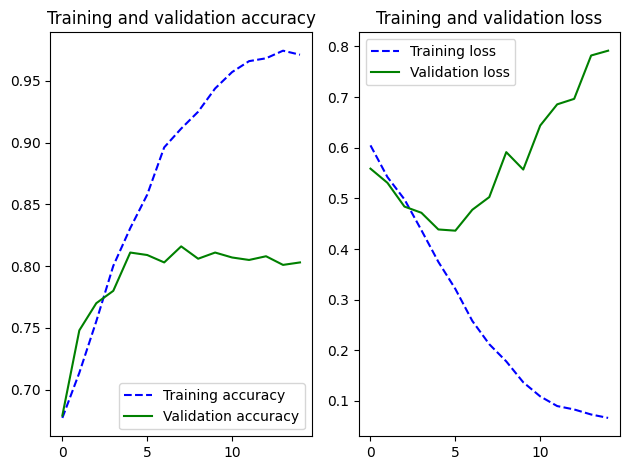

In [21]:
t_prediction_cnn_naif = Analyse_resultats_binaire(cnn_naif,cnn_naif_history,train_generator,test_generator)

Nous obtenons des résultats corrects, mais nous observons un cas clair de sur-apprentissage (overfitting) : le modèle est très performant sur les données d’entraînement, mais il a du mal à généraliser sur de nouvelles images.

### B - Data Augmentation



Pour y remédier, nous allons mettre en place une nouvelle approche.

Une solution efficace pour contrer le sur-apprentissage est l’augmentation de données (data augmentation).
Cette technique consiste à transformer les images existantes pour générer de nouvelles images artificiellement : par exemple en appliquant des rotations, décalages, zooms, retournements, etc.
L’idée est d’augmenter la diversité du jeu de données, ce qui aide le réseau à apprendre des caractéristiques plus robustes et à mieux généraliser.

Nous entraînerons ensuite notre deuxième CNN sur ce jeu de données augmenté.

- On commence par générer le nouveau jeu de données :

In [22]:
train_datagen_augmented = ImageDataGenerator(
    rotation_range = 40,
    rescale = 1./255,
    width_shift_range = 0.2,
    height_shift_range = 0.2,
    shear_range = 0.2,
    zoom_range = 0.2,
    horizontal_flip = True,
    fill_mode='nearest'
)

train_generator_augmented = train_datagen_augmented.flow_from_dataframe(
    train_df,
    img_dir,
    x_col ='Image',
    y_col ='SPECIES_NAME',
    target_size=(img_height, img_width),
    class_mode = 'binary',
    batch_size = batch_size
)

Found 5200 validated image filenames belonging to 2 classes.


- Puis on initialise le nouveau CNN qu'on vient entrainer sur le nouveau jeu de données. Pour cela il suffit de réutiliser la même architecture qu'avant, on change juste les donnée lors de l'entrainement.

In [23]:
cnn_data_augmented = cnn_simple("cnn_data_augmented",img_width, img_height) # On initialise un nouveau réseau (identique au dernier)

cnn_data_augmented.compile(
    loss = 'binary_crossentropy',
    optimizer = Adam(learning_rate=3e-4),
    metrics = ['accuracy'])

t_learning_cnn_data_augmented, cnn_data_augmented_history = Entrainement_nn_binaire(cnn_data_augmented,epochs,train_generator_augmented,validation_generator) # on va l'entrainer avec les données augmentées cette fois

Entrainement de  cnn_data_augmented


/home/ecobicho/.conda/envs/HDDLtensorflow/lib/python3.12/site-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/15
260/260 ━━━━━━━━━━━━━━━━━━━━ 45s 165ms/step - accuracy: 0.6712 - loss: 0.6259 - val_accuracy: 0.6780 - val_loss: 0.5991
Epoch 2/15
260/260 ━━━━━━━━━━━━━━━━━━━━ 42s 159ms/step - accuracy: 0.6777 - loss: 0.5956 - val_accuracy: 0.6780 - val_loss: 0.5616
Epoch 3/15
260/260 ━━━━━━━━━━━━━━━━━━━━ 41s 156ms/step - accuracy: 0.6813 - loss: 0.5827 - val_accuracy: 0.6820 - val_loss: 0.5492
Epoch 4/15
260/260 ━━━━━━━━━━━━━━━━━━━━ 40s 154ms/step - accuracy: 0.6923 - loss: 0.5730 - val_accuracy: 0.6930 - val_loss: 0.5708
Epoch 5/15
260/260 ━━━━━━━━━━━━━━━━━━━━ 41s 158ms/step - accuracy: 0.7037 - loss: 0.5703 - val_accuracy: 0.7100 - val_loss: 0.5303
Epoch 6/15
260/260 ━━━━━━━━━━━━━━━━━━━━ 40s 153ms/step - accuracy: 0.6944 - loss: 0.5700 - val_accuracy: 0.7230 - val_loss: 0.5248
Epoch 7/15
260/260 ━━━━━━━━━━━━━━━━━━━━ 41s 158ms/step - accuracy: 0.7031 - loss: 0.5578 - val_accuracy: 0.7330 - val_loss: 0.5179
Epoch 8/15
260/260 ━━━━━━━━━━━━━━━━━━━━ 40s 155ms/step - accuracy: 0.7131 - loss: 0

- On observe que les performances sont légerement meilleures :

260/260 ━━━━━━━━━━━━━━━━━━━━ 12s 48ms/step - accuracy: 0.7837 - loss: 0.4533
58/58 ━━━━━━━━━━━━━━━━━━━━ 3s 50ms/step - accuracy: 0.7920 - loss: 0.4479
Train accuracy: 0.7836538553237915
Validation accuracy: 0.7919930219650269
Time Prediction: 15.55 seconds


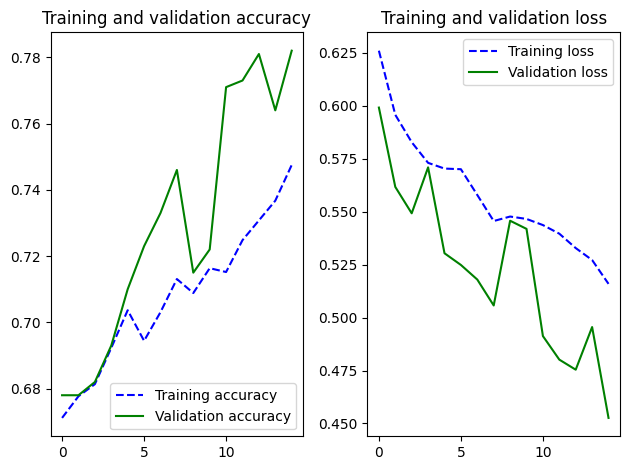

In [24]:
t_prediction_cnn_data_augmented = Analyse_resultats_binaire(cnn_data_augmented,cnn_data_augmented_history,train_generator,test_generator)

Cependant le modèle met beaucoup plus de temps à s'entrainer. On obtient des résultats corrects, mais si on veut faire mieux, il faudrait beaucoup plus de données à notre disposition, ainsi que beaucoup plus de temps.  

### C - Transfer Learning

La dernière solution pour avoir une meilleure précision est d'utiliser le **Transfer Learning**. On va s'aider d'un réseau pré-entrainé (ici **VGG16**) et on va y accroché notre propre *MLP classifier*.
On peut aussi combiner cette approche avec l'augmentation de données. Nous avons vu dans le TP que c'est ce qui donne les meilleurs résultats, nous allons donc directement mettre en place cela. La fonction **VGG16_model_binaire** dans le fichier **Chat_ou_Chiens_lib.py** implémente cette idée.

VGG-16 est un réseau de neurones à convolution d’une profondeur de 16 couches. VGG-16 a été entrainé sur la base de données **ImageNet**, composée de plus de 14 millions d'images avec 20 000 catégories.

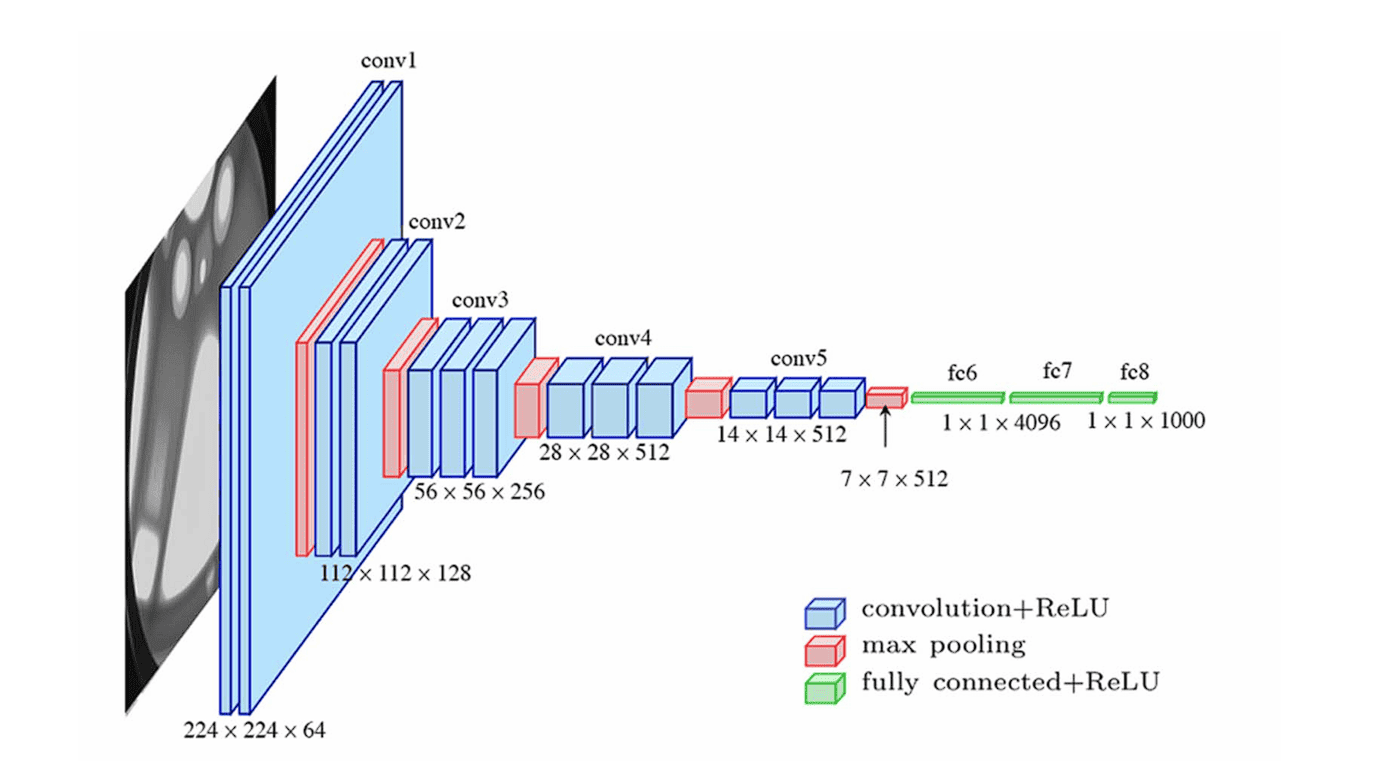

Nous avons resize les images plus tôt pour que cela soit compatible et cohérent avec VGG-16.

In [25]:
vgg_combined = VGG16_model_binaire("VGG16_data_augmented", img_height, img_width, trainable=False)
vgg_combined.summary()

Model: "VGG16_data_augmented"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ vgg16 (Functional)              │ (None, 7, 7, 512)      │    14,714,688 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling2d_2      │ (None, 512)            │             0 │
│ (GlobalAveragePooling2D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_8 (Dense)                 │ (None, 256)            │       131,328 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_9 (Dense)                 │ (None, 1)              │           257 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 14,846,273 (56.63 MB)

 Trainable params: 131,585 (514.00 KB)

 Non-trainable params: 14,714,688 (56.13 MB)

- On entraine notre réseau sur le jeu de données augmenté :

In [26]:
t_learning_vgg_combined_augmented, vgg_combined_history = Entrainement_nn_binaire(vgg_combined,epochs,train_generator_augmented,validation_generator)

Entrainement de  VGG16_data_augmented
Epoch 1/15
260/260 ━━━━━━━━━━━━━━━━━━━━ 51s 158ms/step - accuracy: 0.7538 - loss: 0.5156 - val_accuracy: 0.8730 - val_loss: 0.3657
Epoch 2/15
260/260 ━━━━━━━━━━━━━━━━━━━━ 41s 157ms/step - accuracy: 0.8423 - loss: 0.3823 - val_accuracy: 0.9000 - val_loss: 0.2804
Epoch 3/15
260/260 ━━━━━━━━━━━━━━━━━━━━ 40s 155ms/step - accuracy: 0.8613 - loss: 0.3313 - val_accuracy: 0.9030 - val_loss: 0.2391
Epoch 4/15
260/260 ━━━━━━━━━━━━━━━━━━━━ 40s 155ms/step - accuracy: 0.8804 - loss: 0.3033 - val_accuracy: 0.9100 - val_loss: 0.2191
Epoch 5/15
260/260 ━━━━━━━━━━━━━━━━━━━━ 41s 157ms/step - accuracy: 0.8800 - loss: 0.2887 - val_accuracy: 0.9120 - val_loss: 0.2045
Epoch 6/15
260/260 ━━━━━━━━━━━━━━━━━━━━ 40s 155ms/step - accuracy: 0.8846 - loss: 0.2770 - val_accuracy: 0.9160 - val_loss: 0.2100
Epoch 7/15
260/260 ━━━━━━━━━━━━━━━━━━━━ 41s 159ms/step - accuracy: 0.8819 - loss: 0.2758 - val_accuracy: 0.9120 - val_loss: 0.1980
Epoch 8/15
260/260 ━━━━━━━━━━━━━━━━━━━━ 41s 1

260/260 ━━━━━━━━━━━━━━━━━━━━ 17s 65ms/step - accuracy: 0.9338 - loss: 0.1618
50/50 ━━━━━━━━━━━━━━━━━━━━ 3s 64ms/step - accuracy: 0.9240 - loss: 0.1713
Train accuracy: 0.9338461756706238
Validation accuracy: 0.9240000247955322
Time Prediction: 20.42 seconds


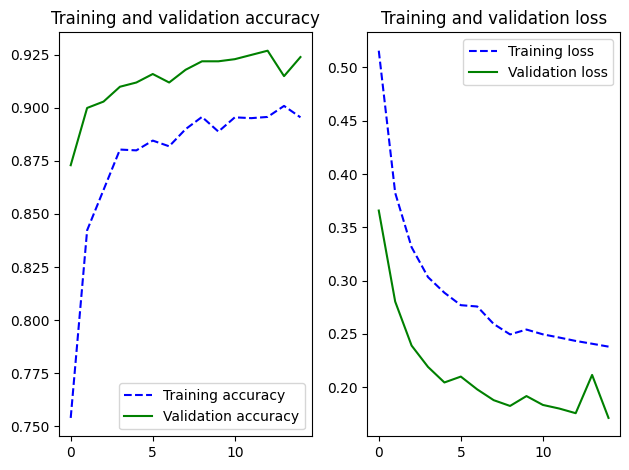

In [27]:
t_prediction_vgg_combined_augmented = Analyse_resultats_binaire(vgg_combined,vgg_combined_history, train_generator, validation_generator)

Les résultats qu'on obtient avec le Transfer Learning sont bons.

### D - Fine Tuning
Pour améliorer encore davantage la précision, nous allons maintenant effectuer une étape de Fine Tuning.

Le Fine Tuning consiste à défiger certaines couches du modèle pré-entraîné afin de réentraîner partiellement le réseau sur notre propre jeu de données.
L’idée est de permettre au modèle d’adapter ses représentations internes (les filtres appris dans les couches profondes) à notre problème spécifique, tout en conservant les connaissances générales issues de l’entraînement initial. 

Nous allons encore utiliser **VVG-16** comme base.

In [28]:
vgg_finetuned = VGG16_model_binaire("VGG16_data_augmented_finetuned", img_height, img_width, trainable=True)
vgg_finetuned.set_weights(vgg_combined.get_weights()) 
vgg_finetuned.summary()


Model: "VGG16_data_augmented_finetuned"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ vgg16 (Functional)              │ (None, 7, 7, 512)      │    14,714,688 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling2d_3      │ (None, 512)            │             0 │
│ (GlobalAveragePooling2D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_10 (Dense)                │ (None, 256)            │       131,328 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_11 (Dense)                │ (None, 1)              │           257 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 14,846,273 (56.63 MB)

 Trainable params: 7,211,009 (27.51 MB)

 Non-trainable params: 7,635,264 (29.13 MB)

In [29]:
epochs = 5
t_learning_vgg_finetuned, vgg_finetuned_history = Entrainement_nn_binaire(vgg_finetuned,epochs,train_generator_augmented,validation_generator,lr=1e-4)

Entrainement de  VGG16_data_augmented_finetuned
Epoch 1/5
260/260 ━━━━━━━━━━━━━━━━━━━━ 44s 157ms/step - accuracy: 0.8717 - loss: 0.3104 - val_accuracy: 0.9090 - val_loss: 0.2413
Epoch 2/5
260/260 ━━━━━━━━━━━━━━━━━━━━ 40s 155ms/step - accuracy: 0.9344 - loss: 0.1622 - val_accuracy: 0.9640 - val_loss: 0.0944
Epoch 3/5
260/260 ━━━━━━━━━━━━━━━━━━━━ 42s 160ms/step - accuracy: 0.9465 - loss: 0.1361 - val_accuracy: 0.9720 - val_loss: 0.0620
Epoch 4/5
260/260 ━━━━━━━━━━━━━━━━━━━━ 42s 162ms/step - accuracy: 0.9675 - loss: 0.0882 - val_accuracy: 0.9800 - val_loss: 0.0484
Epoch 5/5
260/260 ━━━━━━━━━━━━━━━━━━━━ 42s 160ms/step - accuracy: 0.9663 - loss: 0.0903 - val_accuracy: 0.9820 - val_loss: 0.0454
Learning time for 5 epochs : 209 seconds


260/260 ━━━━━━━━━━━━━━━━━━━━ 17s 65ms/step - accuracy: 0.9929 - loss: 0.0221
50/50 ━━━━━━━━━━━━━━━━━━━━ 3s 66ms/step - accuracy: 0.9820 - loss: 0.0454
Train accuracy: 0.992884635925293
Validation accuracy: 0.9819999933242798
Time Prediction: 20.64 seconds


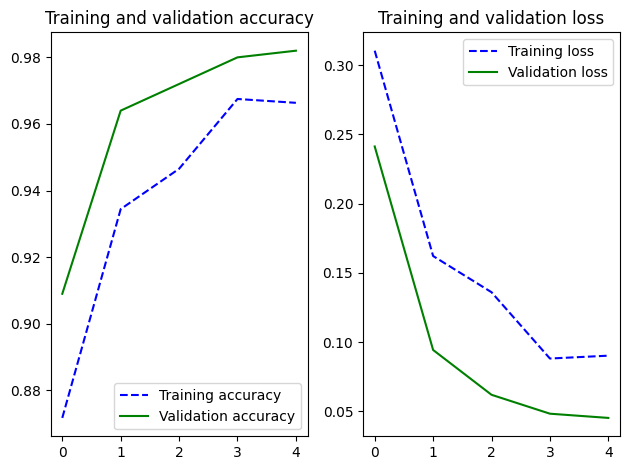

20.63923168182373

In [30]:
Analyse_resultats_binaire(vgg_finetuned,vgg_finetuned_history, train_generator, validation_generator)

On obtient maintenant de très bon résultats avec 98% de précision ! Si on le souhaite, on pourrait continuer le fine-tuning mais ce n'est pas necessaire. 

### E - Comparaison des modèles

In [31]:
def Eval_Test(cnn):
    print("-------------",cnn.name,"-------------")
    cnn.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])
    loss, acc = cnn.evaluate(test_generator)
    print(f"loss = {loss}")
    print(f"accuracy = {acc}\n")

In [32]:
Eval_Test(cnn_naif)
Eval_Test(cnn_data_augmented)
Eval_Test(vgg_combined)
Eval_Test(vgg_finetuned)

------------- cnn_naif -------------
58/58 ━━━━━━━━━━━━━━━━━━━━ 4s 60ms/step - accuracy: 0.7763 - loss: 0.9065
loss = 0.9064764976501465
accuracy = 0.7763272523880005

------------- cnn_data_augmented -------------
58/58 ━━━━━━━━━━━━━━━━━━━━ 4s 64ms/step - accuracy: 0.7920 - loss: 0.4479
loss = 0.44786837697029114
accuracy = 0.7919930219650269

------------- VGG16_data_augmented -------------
58/58 ━━━━━━━━━━━━━━━━━━━━ 9s 142ms/step - accuracy: 0.9217 - loss: 0.1755
loss = 0.1754627674818039
accuracy = 0.9216710329055786

------------- VGG16_data_augmented_finetuned -------------
58/58 ━━━━━━━━━━━━━━━━━━━━ 5s 71ms/step - accuracy: 0.9713 - loss: 0.0796
loss = 0.07964818179607391
accuracy = 0.9712793827056885



On voit que le modèle vgg_finetuned est le plus efficace !

La fonction **predict_animal** utilise notre modèle pour fournir une prédiction sur une image prise au hasard.

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step


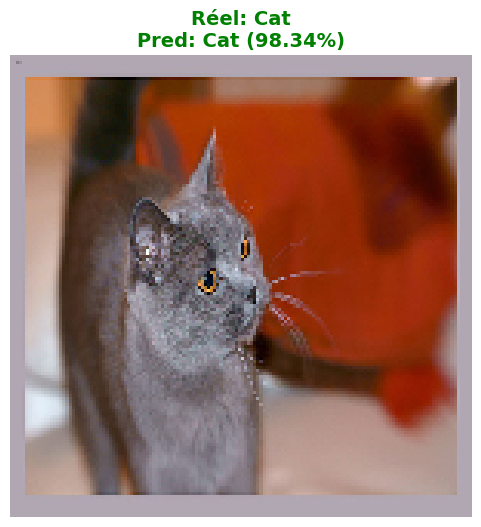

In [26]:
predict_animal(vgg_finetuned, test_df, img_dir)

## 3 - Classification Fine

Le but de cette partie est de déterminer pour chaque image la race de chat ou chien à laquelle elle appartient. Comme il y a beaucoup de classes (37) par rapport au nombre d'images d'entraînement, on s'attends à avoir des résultats peu satisfaisants. On commence par préparer le dataset.

In [33]:
# On part du DataFrame complet : df qui a comme colonnes : mage, CLASS_ID, SPECIES, BREED_ID, BREED_NAME, SPECIES_NAME

data_breed = df[["Image", "BREED_NAME"]].copy() # On crée d’abord une version simplifiée pour la séparation

N_train = 5200          # environ 70% de l'ensemble des données
N_Validation = 1000  

temp_df, train_df_cf = train_test_split(data_breed, test_size=N_train, stratify=data_breed["BREED_NAME"])                    # On prend 5000

test_df_cf, validation_df_cf = train_test_split(temp_df, test_size=N_Validation, stratify=temp_df["BREED_NAME"])    # On prend 1000  dans ce qu'il reste N_test = N_total - (N_train+N_validation)

print("Train set :", train_df_cf.shape)
print("Validation set :", validation_df_cf.shape)
print("Test set :", test_df_cf.shape)
print("\n----Répartition des catégories----\n")
print("Train :", train_df_cf["BREED_NAME"].value_counts())
print("\nValidation :", validation_df_cf["BREED_NAME"].value_counts())
print("\nTest :", test_df_cf["BREED_NAME"].value_counts())

Train set : (5200, 2)
Validation set : (1000, 2)
Test set : (1149, 2)

----Répartition des catégories----

Train : BREED_NAME
Russian_Blue                  142
miniature_pinscher            142
pug                           142
american_bulldog              142
Bengal                        142
beagle                        142
yorkshire_terrier             142
chihuahua                     142
german_shorthaired            142
Birman                        142
leonberger                    142
pomeranian                    142
Persian                       142
boxer                         141
shiba_inu                     141
keeshond                      141
saint_bernard                 141
Maine_Coon                    141
British_Shorthair             141
great_pyrenees                141
english_setter                141
Sphynx                        141
scottish_terrier              141
american_pit_bull_terrier     141
havanese                      141
wheaten_terrier         

### A - Multi-Layer Perceptron (MLP)

On va commencer par utiliser un Multi-Layer Perceptron pour faire la classification. Il y a beaucoup trop de paramètres à apprendre par rapport à la quantité de données, de plus on perd toute l'information spatiale quand on flatten les images pour les donner au MLP, ce n'est pas optimal du tout. On ne s'attend pas à de bons résultats...

Pour que l'apprentissage des paramètres du réseau soit faisable en un temps fini, on doit réduire MASSIVEMENT la taille des images. On les resize en (32,32,3), cela va aussi évidement baisser la qualité des prédictions...

In [8]:
batch_size = 20
img_width = 32
img_height = 32

# Training images
train_datagen = ImageDataGenerator(rescale=1./255)
train_generator = train_datagen.flow_from_dataframe(
    train_df_cf,
    img_dir,
    x_col='Image',
    y_col='BREED_NAME',
    target_size=(img_height, img_width),
    class_mode='sparse',
    batch_size=batch_size)

# Validation images
validation_datagen = ImageDataGenerator(rescale=1./255)
validation_generator = validation_datagen.flow_from_dataframe(
    validation_df_cf,
    img_dir,
    x_col = 'Image',
    y_col = 'BREED_NAME',
    class_mode = 'sparse',
    target_size = (img_height, img_width),
    batch_size = batch_size)

# Test images
test_datagen = ImageDataGenerator(rescale=1./255)
test_generator = test_datagen.flow_from_dataframe(
    test_df_cf,
    img_dir,
    x_col = 'Image',
    y_col = 'BREED_NAME',
    class_mode = 'sparse',
    target_size = (img_height, img_width),
    batch_size = batch_size)

Found 5200 validated image filenames belonging to 37 classes.
Found 1000 validated image filenames belonging to 37 classes.
Found 1149 validated image filenames belonging to 37 classes.


Le MLP qu'on va utiliser est implémenté dans le fichier **Chat_ou_Chiens_lib.py** avec la fonction **mlp**. Il est conçu pour une classification multiclasse (par défaut 37 catégories). Voici le détail de sa structure :
- Couche d'Entrée (Input) : Reçoit des images de dimensions 32x32 pixels en couleur (3 canaux RGB).
- Aplatissement (Flatten) : Cette couche convertit la matrice 2D de l'image (32, 32, 3) en un vecteur unidimensionnel de 3 072 neurones (32×32×3).
- Couches Cachées (Hidden Layers) :
    - Dense (128) : Une première couche dense de 128 neurones avec une activation ReLU pour introduire de la non-linéarité.
    - Dropout (0.4) : Une couche de régularisation qui "désactive" aléatoirement 40% des neurones pendant l'entraînement pour limiter le sur-apprentissage (overfitting).
    - Dense (128) + Dropout (0.4) : Une seconde répétition pour augmenter la capacité d'abstraction du modèle.
- Couche de Sortie (Output) : * Composée de 37 neurones (correspondant au nombre de classes).
    - Utilise la fonction d'activation Softmax, ce qui permet d'obtenir une distribution de probabilité : la somme des sorties est égale à 1, facilitant l'identification de la classe la plus probable.

In [9]:
mlp_simple=mlp("mlp_simple")
mlp_simple.summary()  

Model: "mlp_simple"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ flatten (Flatten)               │ (None, 3072)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 128)            │       393,344 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 128)            │        16,512 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 37)             │         4,773 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 414,629 (1.58 MB)

 Trainable params: 414,629 (1.58 MB)

 Non-trainable params: 0 (0.00 B)

La fonction pour l'entrainement est aussi dans le fichier **Chat_ou_Chiens_lib.py**.

In [30]:
epochs = 10
t_learning_mlp_naif, mlp_naif_history = Entrainement_nn_fine(mlp_simple, epochs, train_generator, validation_generator)

Entrainement de  mlp_simple
Epoch 1/10


/home/davodeau/.conda/envs/HDDLtensorflow/lib/python3.12/site-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()
2026-01-22 15:42:31.893397: I external/local_xla/xla/service/gpu/autotuning/dot_search_space.cc:208] All configs were filtered out because none of them sufficiently match the hints. Maybe the hints set does not contain a good representative set of valid configs? Working around this by using the full hints set instead.
2026-01-22 15:42:31.893449: I external/local_xla/xla/service/gpu/autotuning/dot_search_space.cc:208] All configs were filtered out because none of them sufficiently match the hints. Maybe the hints set does not contain a good representative set of valid configs? Working around

260/260 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step - accuracy: 0.0251 - loss: 3.6889

2026-01-22 15:42:44.488297: I external/local_xla/xla/service/gpu/autotuning/dot_search_space.cc:208] All configs were filtered out because none of them sufficiently match the hints. Maybe the hints set does not contain a good representative set of valid configs? Working around this by using the full hints set instead.
2026-01-22 15:42:45.030023: I external/local_xla/xla/stream_executor/cuda/subprocess_compilation.cc:346] ptxas warning : Registers are spilled to local memory in function 'gemm_fusion_dot_34', 292 bytes spill stores, 292 bytes spill loads

2026-01-22 15:42:45.094643: I external/local_xla/xla/stream_executor/cuda/subprocess_compilation.cc:346] ptxas warning : Registers are spilled to local memory in function 'gemm_fusion_dot_34', 48 bytes spill stores, 48 bytes spill loads



260/260 ━━━━━━━━━━━━━━━━━━━━ 16s 51ms/step - accuracy: 0.0285 - loss: 3.6416 - val_accuracy: 0.0340 - val_loss: 3.6091
Epoch 2/10
260/260 ━━━━━━━━━━━━━━━━━━━━ 12s 47ms/step - accuracy: 0.0290 - loss: 3.6125 - val_accuracy: 0.0270 - val_loss: 3.6069
Epoch 3/10
260/260 ━━━━━━━━━━━━━━━━━━━━ 13s 50ms/step - accuracy: 0.0281 - loss: 3.6101 - val_accuracy: 0.0340 - val_loss: 3.6082
Epoch 4/10
260/260 ━━━━━━━━━━━━━━━━━━━━ 14s 54ms/step - accuracy: 0.0310 - loss: 3.6080 - val_accuracy: 0.0380 - val_loss: 3.6045
Epoch 5/10
260/260 ━━━━━━━━━━━━━━━━━━━━ 14s 54ms/step - accuracy: 0.0327 - loss: 3.5980 - val_accuracy: 0.0450 - val_loss: 3.5824
Epoch 6/10
260/260 ━━━━━━━━━━━━━━━━━━━━ 13s 50ms/step - accuracy: 0.0346 - loss: 3.5899 - val_accuracy: 0.0510 - val_loss: 3.5663
Epoch 7/10
260/260 ━━━━━━━━━━━━━━━━━━━━ 12s 47ms/step - accuracy: 0.0419 - loss: 3.5709 - val_accuracy: 0.0460 - val_loss: 3.5496
Epoch 8/10
260/260 ━━━━━━━━━━━━━━━━━━━━ 13s 51ms/step - accuracy: 0.0429 - loss: 3.5569 - val_accurac

Pour voir les performances de notre modèle, on affiche une matrice de confusion à l'aide de la fonction **ANalyse_resultats** dans le fichier **Chat_ou_Chiens_lib.py**. Si le modèle est parfait, on devrait observé une matrice diagonale.

260/260 ━━━━━━━━━━━━━━━━━━━━ 10s 39ms/step - accuracy: 0.0627 - loss: 3.4997
50/50 ━━━━━━━━━━━━━━━━━━━━ 2s 40ms/step - accuracy: 0.0540 - loss: 3.5084
50/50 ━━━━━━━━━━━━━━━━━━━━ 2s 40ms/step
Train accuracy: 0.0626923069357872
Validation accuracy: 0.05400000140070915
Time Prediction: 14.94 seconds


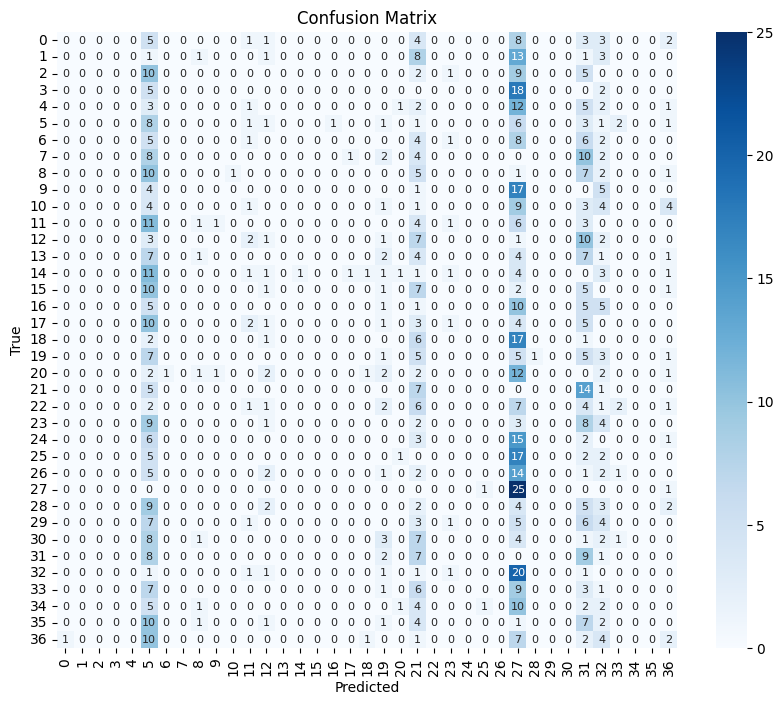

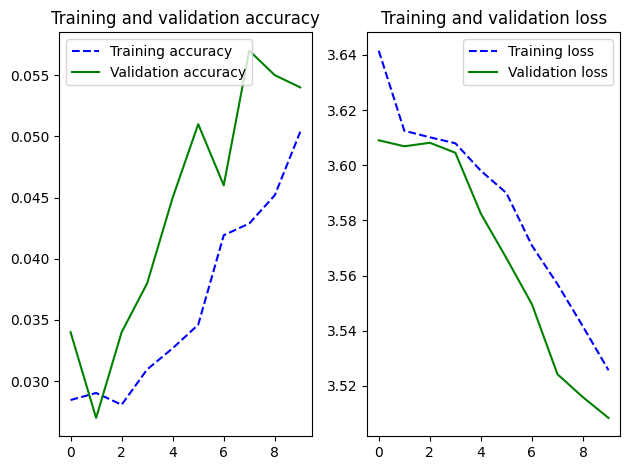

In [31]:
t_prediction_mlp_naif = Analyse_resultats(mlp_simple,mlp_naif_history, train_generator, validation_generator)

On observe que notre modèle prédit seulement une classe en majorité. La précision est très mauvaise, mais c'était attendu. On va donc essayer un autre modèle.

### B - convolutional Neural Network (CNN)

Dans un CNN on utilise des couches de convolutions. Cela implique qu'il y a beaucoup moins de poids à apprendre que dans un MLP. Le nombre de poids ne dépend pas non plus de la taille d'entrée des images. Nous n'avons plus besoin d'utiliser des images (32,32,3), on peut prendre une taille plus grande. Ici on va prendre (224,224,3). On commence par préparer le dataset.

In [34]:
batch_size = 20
img_width = 224
img_height = 224


# Training images
train_datagen = ImageDataGenerator(rescale=1./255)
train_generator = train_datagen.flow_from_dataframe(
    train_df_cf,
    img_dir,
    x_col='Image',
    y_col='BREED_NAME',
    target_size=(img_height, img_width),
    class_mode='sparse',
    batch_size=batch_size)

# Validation images
validation_datagen = ImageDataGenerator(rescale=1./255)
validation_generator = validation_datagen.flow_from_dataframe(
    validation_df_cf,
    img_dir,
    x_col = 'Image',
    y_col = 'BREED_NAME',
    class_mode = 'sparse',
    target_size = (img_height, img_width),
    batch_size = batch_size)

# Test images
test_datagen = ImageDataGenerator(rescale=1./255)
test_generator = test_datagen.flow_from_dataframe(
    test_df_cf,
    img_dir,
    x_col = 'Image',
    y_col = 'BREED_NAME',
    class_mode = 'sparse',
    target_size = (img_height, img_width),
    batch_size = batch_size)

Found 5200 validated image filenames belonging to 37 classes.
Found 1000 validated image filenames belonging to 37 classes.
Found 1149 validated image filenames belonging to 37 classes.


Le CNN qu'on utilise détaillé ici :

1. Bloc d'extraction de caractéristiques (Convolution & Pooling)

Le modèle utilise trois blocs successifs de complexité croissante (32, 64, puis 128 filtres) :

- Conv2D (3x3) : Applique des filtres pour détecter des motifs. Le padding='same' permet de conserver les dimensions spatiales après la convolution.
- BatchNormalization : Normalise les activations à la sortie de la convolution. Cela accélère l'entraînement et agit comme une forme de régularisation pour stabiliser l'apprentissage.
- MaxPooling2D : Réduit de moitié la résolution spatiale (largeur et hauteur), ce qui diminue le nombre de paramètres et aide le réseau à devenir invariant aux petites translations de l'objet dans l'image.

2. Transition et Classification

- GlobalAveragePooling2D : Au lieu d'utiliser une couche Flatten classique, cette couche calcule la moyenne de chaque carte de caractéristiques. Cela réduit drastiquement le risque de sur-apprentissage (overfitting) en diminuant le nombre de poids dans les couches denses finales.
- Dense (128) & Dropout (0.5) : Une couche entièrement connectée pour interpréter les caractéristiques extraites, protégée par un Dropout important (50%) pour forcer le réseau à ne pas dépendre de neurones spécifiques.
- Dense (37) & Softmax : La couche de sortie produit une distribution de probabilité sur les 37 races d'animaux.

Il est implémenté dans la fonction **CNN** dans le fichier **Chat_ou_Chiens_lib.py**.

In [35]:
cnn=CNN("CNN",img_height, img_width)
cnn.summary()

Model: "CNN"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d_38 (Conv2D)              │ (None, 224, 224, 32)   │           896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_32          │ (None, 224, 224, 32)   │           128 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_6 (MaxPooling2D)  │ (None, 112, 112, 32)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_39 (Conv2D)              │ (None, 112, 112, 64)   │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_33          │ (None, 112, 112, 64)   │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_7 (MaxPooling2D)  │ (None, 56, 56, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_40 (Conv2D)              │ (None, 56, 56, 128)    │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_34          │ (None, 56, 56, 128)    │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_8 (MaxPooling2D)  │ (None, 28, 28, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling2d_4      │ (None, 128)            │             0 │
│ (GlobalAveragePooling2D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_12 (Dense)                │ (None, 128)            │        16,512 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_4 (Dropout)             │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_13 (Dense)                │ (None, 37)             │         4,773 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 115,429 (450.89 KB)

 Trainable params: 114,981 (449.14 KB)

 Non-trainable params: 448 (1.75 KB)

On entraine le modèle avec une vingtaine d'epochs.

Entrainement de  CNN
Epoch 1/20


/home/ecobicho/.conda/envs/HDDLtensorflow/lib/python3.12/site-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()
2026-01-23 11:10:38.723288: I external/local_xla/xla/service/gpu/autotuning/dot_search_space.cc:208] All configs were filtered out because none of them sufficiently match the hints. Maybe the hints set does not contain a good representative set of valid configs? Working around this by using the full hints set instead.
2026-01-23 11:10:38.723349: I external/local_xla/xla/service/gpu/autotuning/dot_search_space.cc:208] All configs were filtered out because none of them sufficiently match the hints. Maybe the hints set does not contain a good representative set of valid configs? Working around

260/260 ━━━━━━━━━━━━━━━━━━━━ 24s 63ms/step - accuracy: 0.0412 - loss: 3.6686 - val_accuracy: 0.0270 - val_loss: 3.6827
Epoch 2/20
260/260 ━━━━━━━━━━━━━━━━━━━━ 15s 56ms/step - accuracy: 0.0556 - loss: 3.5646 - val_accuracy: 0.0390 - val_loss: 3.5773
Epoch 3/20
260/260 ━━━━━━━━━━━━━━━━━━━━ 15s 56ms/step - accuracy: 0.0588 - loss: 3.5292 - val_accuracy: 0.0780 - val_loss: 3.4788
Epoch 4/20
260/260 ━━━━━━━━━━━━━━━━━━━━ 15s 58ms/step - accuracy: 0.0744 - loss: 3.4940 - val_accuracy: 0.0830 - val_loss: 3.4589
Epoch 5/20
260/260 ━━━━━━━━━━━━━━━━━━━━ 14s 55ms/step - accuracy: 0.0779 - loss: 3.4703 - val_accuracy: 0.0890 - val_loss: 3.4068
Epoch 6/20
260/260 ━━━━━━━━━━━━━━━━━━━━ 16s 60ms/step - accuracy: 0.0802 - loss: 3.4525 - val_accuracy: 0.1060 - val_loss: 3.3839
Epoch 7/20
260/260 ━━━━━━━━━━━━━━━━━━━━ 16s 60ms/step - accuracy: 0.0913 - loss: 3.4175 - val_accuracy: 0.1090 - val_loss: 3.3659
Epoch 8/20
260/260 ━━━━━━━━━━━━━━━━━━━━ 16s 60ms/step - accuracy: 0.0915 - loss: 3.4091 - val_accurac

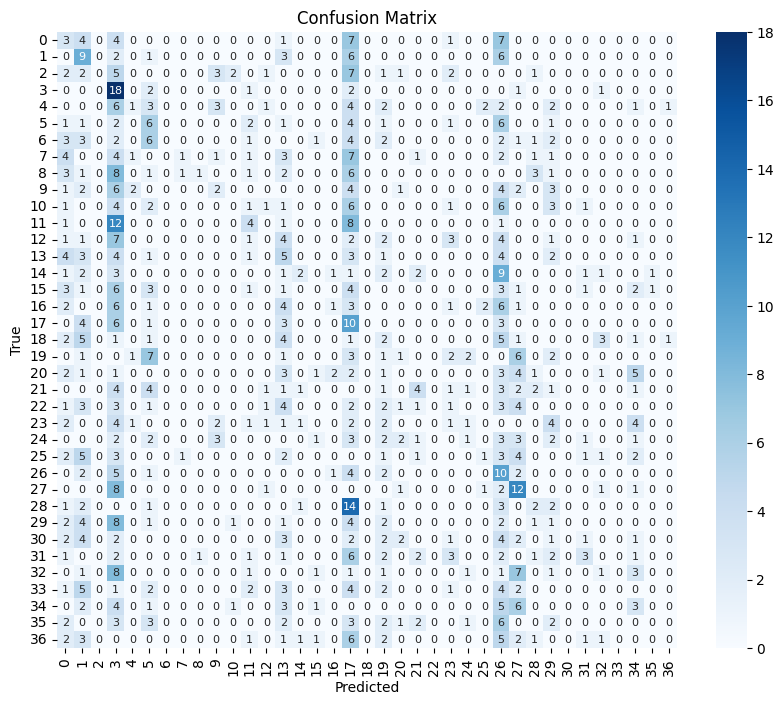

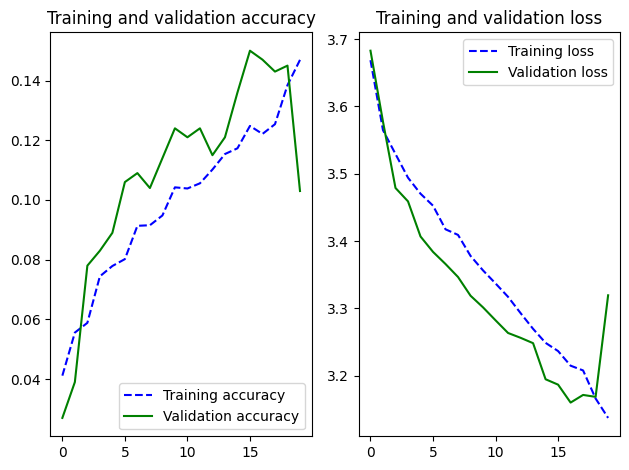

In [36]:
epochs = 20
t_learning_cnn, cnn_history = Entrainement_nn_fine(cnn, epochs, train_generator, validation_generator)
t_prediction_cnn_naif = Analyse_resultats(cnn, cnn_history, train_generator, validation_generator)

Même avec 20 epochs, on obtient encore des résultats très mauvais !

### C - Transfert Learning, Data augmentation et Fine Tuning

Sachant que notre "CNN simple" a de très mauvais résultats, on va directement mettre en place un CNN avec du Transfert Learning, de l'augmentation de données et du Fine Tuning. On a vu avec la partie sur la classification binaire que ca devrait bien mieux fonctionner.  
  
On commence par préparer le jeu de données augmenté.

On choisit de re-dimensionner les images en 224 par 224 car c'est la dimension d'entrée des réseaux que nous allons utiliser pour le transfer learning plus bas (VGG16, ResNet50).

In [37]:
batch_size = 20
img_width = 224
img_height = 224

train_datagen_augmented = ImageDataGenerator(
    rescale=1./255,
    rotation_range=10,
    zoom_range=0.1,
    width_shift_range=0.05,
    height_shift_range=0.05,
    horizontal_flip=True
)
train_generator_augmented = train_datagen_augmented.flow_from_dataframe(
    train_df_cf,
    img_dir,
    x_col ='Image',
    y_col ='BREED_NAME',
    target_size=(img_height, img_width),
    class_mode = 'sparse',
    batch_size = batch_size
)

Found 5200 validated image filenames belonging to 37 classes.


On fait le Transfert Learning et la Data Augmentation avec un learning rate de 0.001.
On utilise **VGG-16** comme base.

In [38]:
VGG_augmented = VGG16_model_classif_fine("VGG16_data_augmented", img_height, img_width, trainable=False)
VGG_augmented.summary()

epochs = 20
t_learning_cnn_data_augmented, cnn_data_augmented_history = Entrainement_nn_fine(VGG_augmented, epochs, train_generator_augmented, validation_generator, lr=1e-3)

Model: "VGG16_data_augmented"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ vgg16 (Functional)              │ (None, 7, 7, 512)      │    14,714,688 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling2d_5      │ (None, 512)            │             0 │
│ (GlobalAveragePooling2D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_14 (Dense)                │ (None, 256)            │       131,328 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_5 (Dropout)             │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_15 (Dense)                │ (None, 37)             │         9,509 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 14,855,525 (56.67 MB)

 Trainable params: 140,837 (550.14 KB)

 Non-trainable params: 14,714,688 (56.13 MB)

Entrainement de  VGG16_data_augmented


/home/ecobicho/.conda/envs/HDDLtensorflow/lib/python3.12/site-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/20
260/260 ━━━━━━━━━━━━━━━━━━━━ 44s 158ms/step - accuracy: 0.0692 - loss: 3.4624 - val_accuracy: 0.2050 - val_loss: 3.1358
Epoch 2/20
260/260 ━━━━━━━━━━━━━━━━━━━━ 40s 154ms/step - accuracy: 0.1558 - loss: 2.9850 - val_accuracy: 0.3110 - val_loss: 2.6669
Epoch 3/20
260/260 ━━━━━━━━━━━━━━━━━━━━ 39s 152ms/step - accuracy: 0.2185 - loss: 2.6668 - val_accuracy: 0.3700 - val_loss: 2.3898
Epoch 4/20
260/260 ━━━━━━━━━━━━━━━━━━━━ 40s 153ms/step - accuracy: 0.2748 - loss: 2.4400 - val_accuracy: 0.4290 - val_loss: 2.1777
Epoch 5/20
260/260 ━━━━━━━━━━━━━━━━━━━━ 39s 151ms/step - accuracy: 0.3038 - loss: 2.2960 - val_accuracy: 0.4680 - val_loss: 2.0312
Epoch 6/20
260/260 ━━━━━━━━━━━━━━━━━━━━ 39s 151ms/step - accuracy: 0.3383 - loss: 2.1829 - val_accuracy: 0.4920 - val_loss: 1.9304
Epoch 7/20
260/260 ━━━━━━━━━━━━━━━━━━━━ 39s 151ms/step - accuracy: 0.3750 - loss: 2.0881 - val_accuracy: 0.5200 - val_loss: 1.8281
Epoch 8/20
260/260 ━━━━━━━━━━━━━━━━━━━━ 39s 151ms/step - accuracy: 0.3856 - loss: 2

Puis on vient faire le Finetuning avec un learning rate plus faible (0.0001) pour ne pas écraser tous les poids de VGG-16.

In [39]:
VGG_augmented_finetuned = VGG16_model_classif_fine("VGG16_data_augmented_finetuned", img_height, img_width, trainable=True)
VGG_augmented_finetuned.set_weights(VGG_augmented.get_weights()) 
VGG_augmented_finetuned.summary()

epochs = 10
t_learning_VGG_augmented_finetuned, VGG_augmented_finetuned_history = Entrainement_nn_fine(VGG_augmented_finetuned, epochs, train_generator_augmented, validation_generator, lr=1e-4)

Model: "VGG16_data_augmented_finetuned"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ vgg16 (Functional)              │ (None, 7, 7, 512)      │    14,714,688 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling2d_6      │ (None, 512)            │             0 │
│ (GlobalAveragePooling2D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_16 (Dense)                │ (None, 256)            │       131,328 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_6 (Dropout)             │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_17 (Dense)                │ (None, 37)             │         9,509 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 14,855,525 (56.67 MB)

 Trainable params: 7,220,261 (27.54 MB)

 Non-trainable params: 7,635,264 (29.13 MB)

Entrainement de  VGG16_data_augmented_finetuned
Epoch 1/10
260/260 ━━━━━━━━━━━━━━━━━━━━ 44s 156ms/step - accuracy: 0.5002 - loss: 1.5987 - val_accuracy: 0.6200 - val_loss: 1.1512
Epoch 2/10
260/260 ━━━━━━━━━━━━━━━━━━━━ 41s 156ms/step - accuracy: 0.6279 - loss: 1.1440 - val_accuracy: 0.6850 - val_loss: 0.9907
Epoch 3/10
260/260 ━━━━━━━━━━━━━━━━━━━━ 39s 150ms/step - accuracy: 0.6844 - loss: 0.9618 - val_accuracy: 0.7210 - val_loss: 0.9185
Epoch 4/10
260/260 ━━━━━━━━━━━━━━━━━━━━ 39s 150ms/step - accuracy: 0.7323 - loss: 0.8056 - val_accuracy: 0.7060 - val_loss: 0.9338
Epoch 5/10
260/260 ━━━━━━━━━━━━━━━━━━━━ 39s 149ms/step - accuracy: 0.7706 - loss: 0.6894 - val_accuracy: 0.7320 - val_loss: 0.8416
Epoch 6/10
260/260 ━━━━━━━━━━━━━━━━━━━━ 39s 150ms/step - accuracy: 0.7929 - loss: 0.6040 - val_accuracy: 0.7200 - val_loss: 0.8942
Epoch 7/10
260/260 ━━━━━━━━━━━━━━━━━━━━ 40s 152ms/step - accuracy: 0.8210 - loss: 0.5244 - val_accuracy: 0.7580 - val_loss: 0.8397
Epoch 8/10
260/260 ━━━━━━━━━━━━━━━━

260/260 ━━━━━━━━━━━━━━━━━━━━ 37s 143ms/step - accuracy: 0.9500 - loss: 0.1847
50/50 ━━━━━━━━━━━━━━━━━━━━ 3s 64ms/step - accuracy: 0.7590 - loss: 0.8913
50/50 ━━━━━━━━━━━━━━━━━━━━ 4s 62ms/step
Train accuracy: 0.949999988079071
Validation accuracy: 0.7590000033378601
Time Prediction: 44.80 seconds


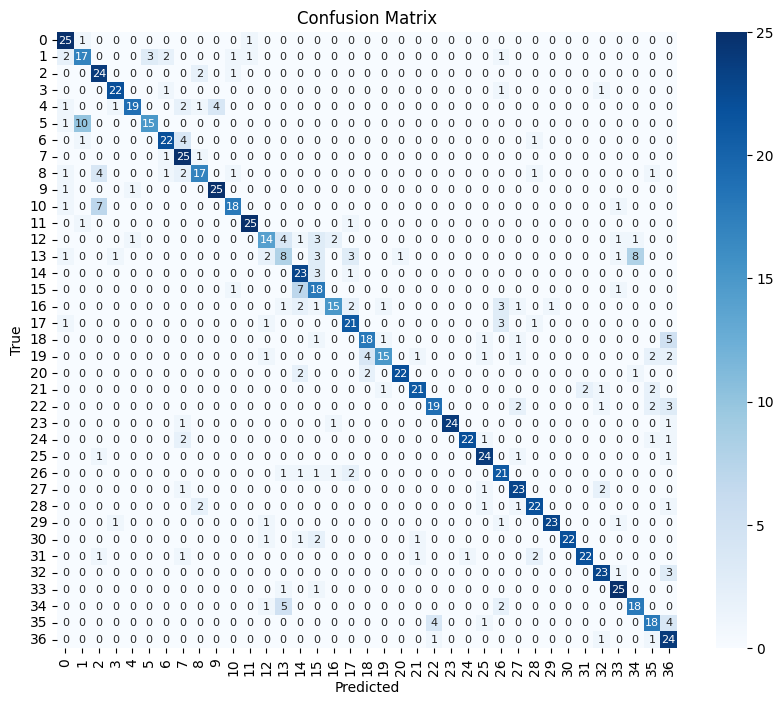

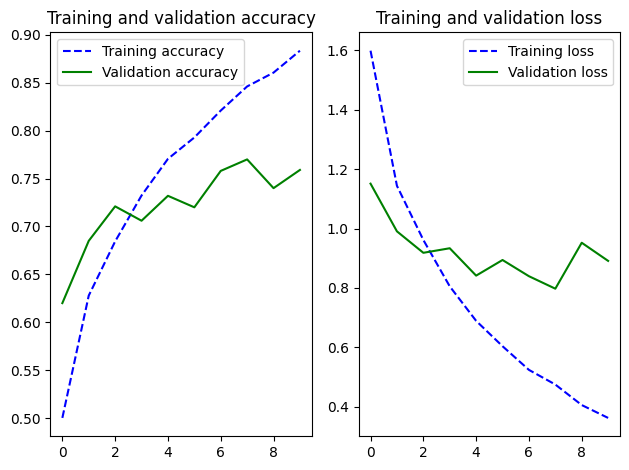


Total des paires de races confondues : 142

 15 confusions les plus fréquentes
                Vraie Race               Race Prédite  Nombre d'erreurs
              Egyptian_Mau                     Bengal                10
 american_pit_bull_terrier staffordshire_bull_terrier                 8
                   Siamese                     Birman                 7
                    beagle               basset_hound                 7
staffordshire_bull_terrier  american_pit_bull_terrier                 5
    english_cocker_spaniel          yorkshire_terrier                 5
          american_bulldog  american_pit_bull_terrier                 4
                Maine_Coon                    Persian                 4
                   Ragdoll                     Birman                 4
           wheaten_terrier          yorkshire_terrier                 4
         British_Shorthair               Russian_Blue                 4
           wheaten_terrier                   havanese   

In [40]:
t_prediction_VGG_augmented_finetuned = Analyse_resultats(VGG_augmented_finetuned, VGG_augmented_finetuned_history,  train_generator_augmented, validation_generator,confusion_races=True)

On observe des résultats satisfaisants, mais tout de même un leger cas de sur-apprentissage. On a peut-être fait un petit peu trop d'epoch lors du Fine Tuning.  

Au niveau de la confusion des races proches On remarque dans les 2 cas les plus importants que la race Birman est prédite à la place des races Ragdoll et Siamese. On va afficher des images d'animaux de ces races ci-dessous pour essayer de comprendre pourquoi le réseau à du mal à distinguer ces races :

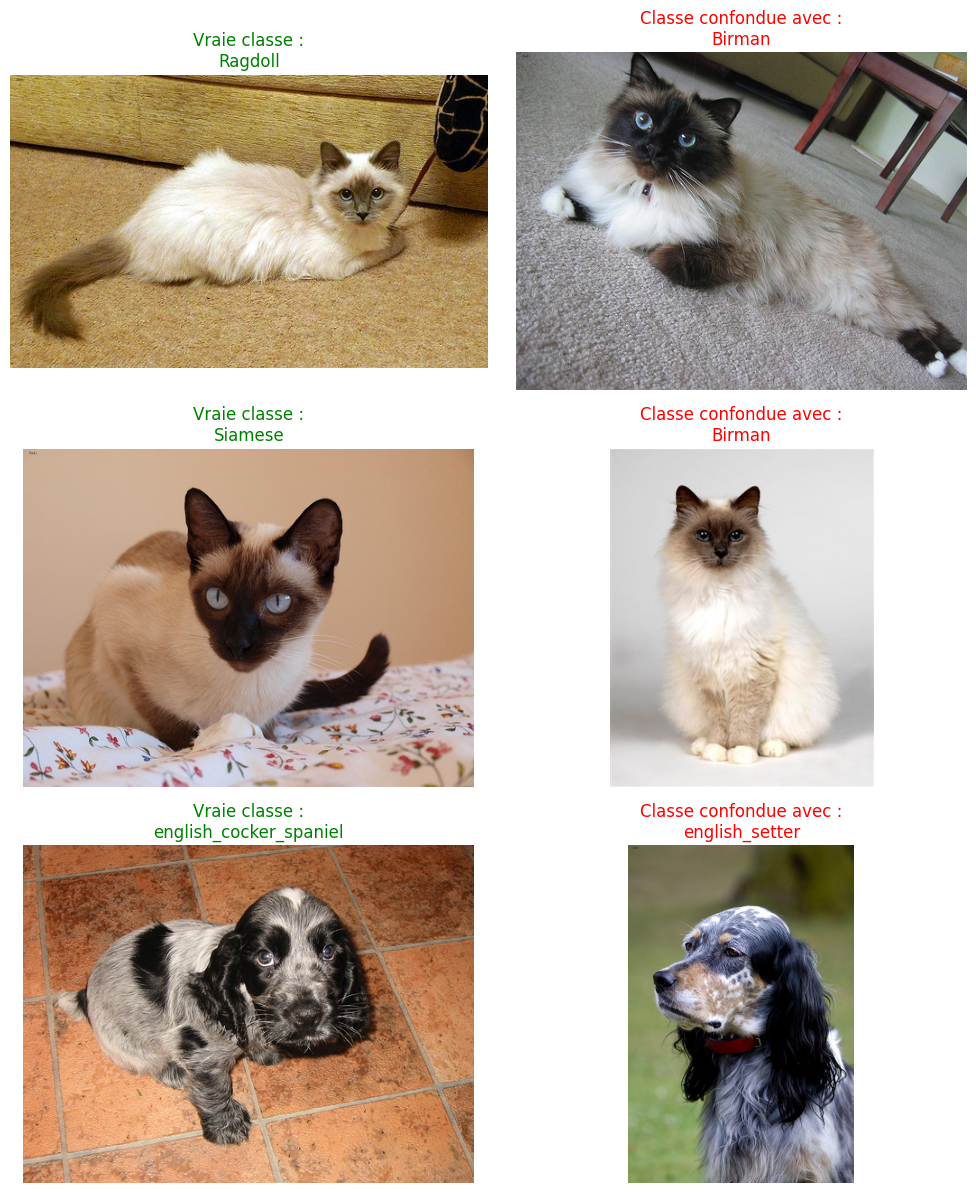

In [44]:
CHEMIN_DOSSIER_IMAGES = "oxford-iiit-pet/images"
top_confusions = [("Ragdoll", "Birman"),("Siamese", "Birman"),("english_cocker_spaniel", "english_setter")]

plot_confused_pairs(top_confusions, validation_df_cf, CHEMIN_DOSSIER_IMAGES)

On voit bien ici que les classes confondues sont très proches visuellement, même pour un humain à l'oeil. Les chats siamese, ragdoll et birman ont tout les trois des yeux bleus, un pelage blanc et des oreilles et des poils du visage noirs.

La fonction suivante utilise notre modèle pour fournir une prédiction sur des images prises au hasard.

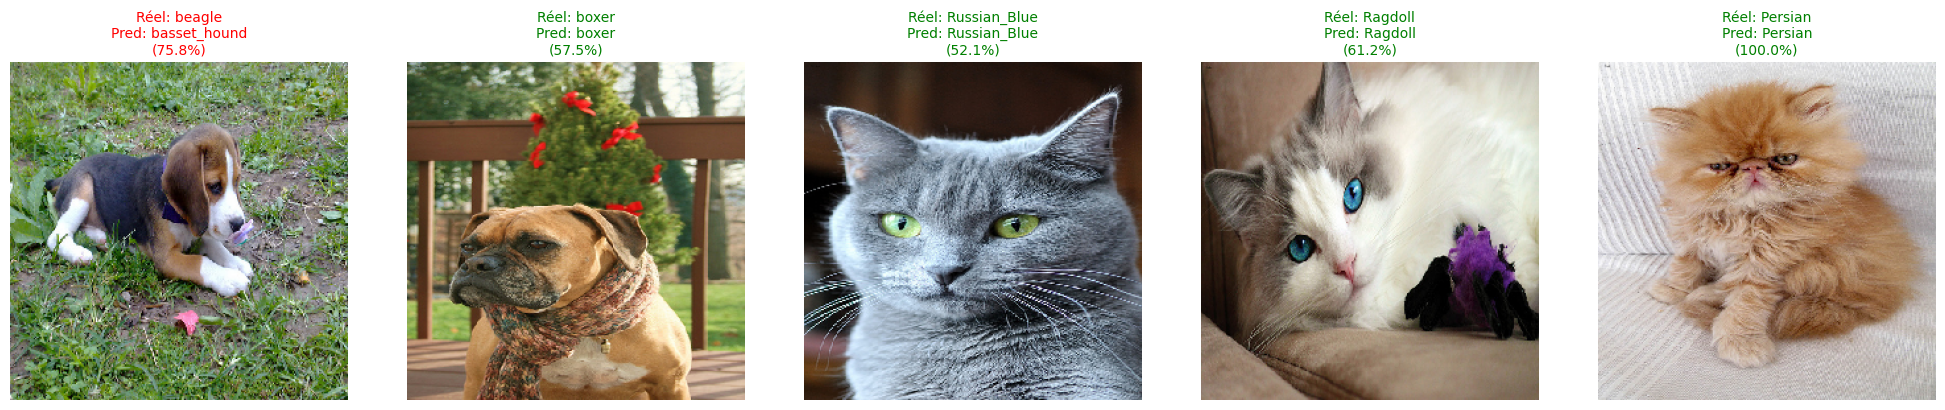

In [48]:
predict_breed_samples(VGG_augmented_finetuned, test_df_cf, img_dir, test_generator, img_height, img_width, n_samples=5)

## 4- Segmentation des animaux

On cherche maintenant à segmenter les animaux. On va faire de la ségmentation binaire : corps de l'animal vs fond de l'image.
Pour faire cela on va utiliser un reseau U-Net. L'image ci-dessous est un exemple d'architecture U-net. Le  U-Net a une architecture en forme de "U" composée de deux parties : 
- une phase de contraction (encodeur) qui capture le contexte et les caractéristiques globales de l'image 
- une phase d'expansion (décodeur) 
- des connexions directes (skip connections) transférant les détails spatiaux haute résolution.

![](https://huggingface.co/datasets/huggingface/documentation-images/resolve/main/unet-model.png)

Nous avons implémenter notre U-Net dans le fichier **Chat_ou_Chiens_lib.py** avec la fonction **unet_model**.

On commence par charger les données, ainsi que les masques :

In [46]:
# On part du DataFrame complet : df qui a comme colonnes : Image, CLASS_ID, SPECIES, BREED_ID, BREED_NAME, SPECIES_NAME
data_segmentation = df[["Image"]].copy()  # On crée une version simplifiée pour la séparation

N_train = 5200          # environ 70% de l'ensemble des données
N_Validation = 1000  
temp_df, train_df_seg = train_test_split(data_segmentation, test_size=N_train, random_state=42)
test_df_seg, validation_df_seg = train_test_split(temp_df, test_size=N_Validation, random_state=42)

print("Train set :", train_df_seg.shape)
print("Validation set :", validation_df_seg.shape)
print("Test set :", test_df_seg.shape)

Train set : (5200, 1)
Validation set : (1000, 1)
Test set : (1149, 1)


In [47]:
# Créer les SegmentationDataLoaders
batch_size = 20
img_width = 128
img_height = 128
mask_dir = "./oxford-iiit-pet/annotations/trimaps"

train_loader_seg = SegmentationDataLoader(
    train_df_seg,
    img_dir,
    mask_dir,
    img_size=(img_width, img_height),
    batch_size=batch_size,
    augment=True
)

val_loader_seg = SegmentationDataLoader(
    validation_df_seg,
    img_dir,
    mask_dir,
    img_size=(img_width, img_height),
    batch_size=batch_size,
    augment=False
)

test_loader_seg = SegmentationDataLoader(
    test_df_seg,
    img_dir,
    mask_dir,
    img_size=(img_width, img_height),
    batch_size=batch_size,
    augment=False
)

On entraine le U-Net avec une dizaine d'epochs

Entrainement de  functional_75


/home/ecobicho/.conda/envs/HDDLtensorflow/lib/python3.12/site-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/10
260/260 ━━━━━━━━━━━━━━━━━━━━ 50s 119ms/step - accuracy: 0.9192 - loss: 0.2000 - val_accuracy: 0.9378 - val_loss: 0.1616
Epoch 2/10
260/260 ━━━━━━━━━━━━━━━━━━━━ 20s 75ms/step - accuracy: 0.9419 - loss: 0.1449 - val_accuracy: 0.9414 - val_loss: 0.1488
Epoch 3/10
260/260 ━━━━━━━━━━━━━━━━━━━━ 20s 76ms/step - accuracy: 0.9471 - loss: 0.1309 - val_accuracy: 0.9433 - val_loss: 0.1497
Epoch 4/10
260/260 ━━━━━━━━━━━━━━━━━━━━ 19s 74ms/step - accuracy: 0.9507 - loss: 0.1208 - val_accuracy: 0.9457 - val_loss: 0.1404
Epoch 5/10
260/260 ━━━━━━━━━━━━━━━━━━━━ 20s 75ms/step - accuracy: 0.9545 - loss: 0.1116 - val_accuracy: 0.9425 - val_loss: 0.1519
Epoch 6/10
260/260 ━━━━━━━━━━━━━━━━━━━━ 20s 77ms/step - accuracy: 0.9564 - loss: 0.1062 - val_accuracy: 0.9397 - val_loss: 0.1586
Epoch 7/10
260/260 ━━━━━━━━━━━━━━━━━━━━ 19s 74ms/step - accuracy: 0.9593 - loss: 0.0990 - val_accuracy: 0.9467 - val_loss: 0.1466
Epoch 8/10
260/260 ━━━━━━━━━━━━━━━━━━━━ 19s 74ms/step - accuracy: 0.9608 - loss: 0.0949 -

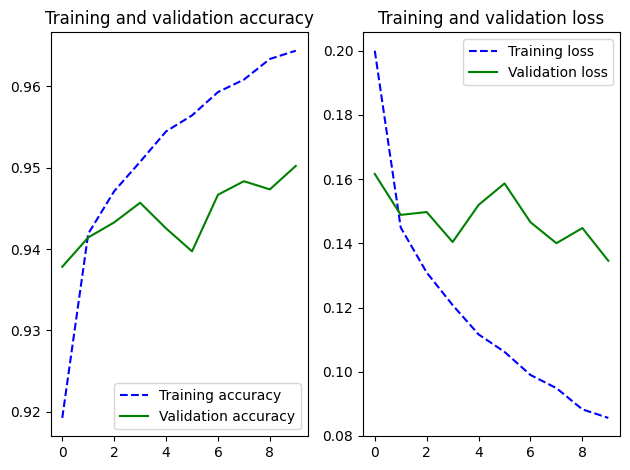

In [48]:
epochs = 10

Unet = unet_model(output_channels=1)  # 1 canal pour foreground vs background
t_learning_unet, unet_history = Entrainement_nn_segmentation(Unet,epochs,train_loader_seg, val_loader_seg, lr=1e-4)
plot_training_analysis(unet_history)

On peut visualiser ce que fait notre U-Net avec la fonction **Visualisation_Prediction_U_Net**.

1/1 ━━━━━━━━━━━━━━━━━━━━ 4s 4s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step


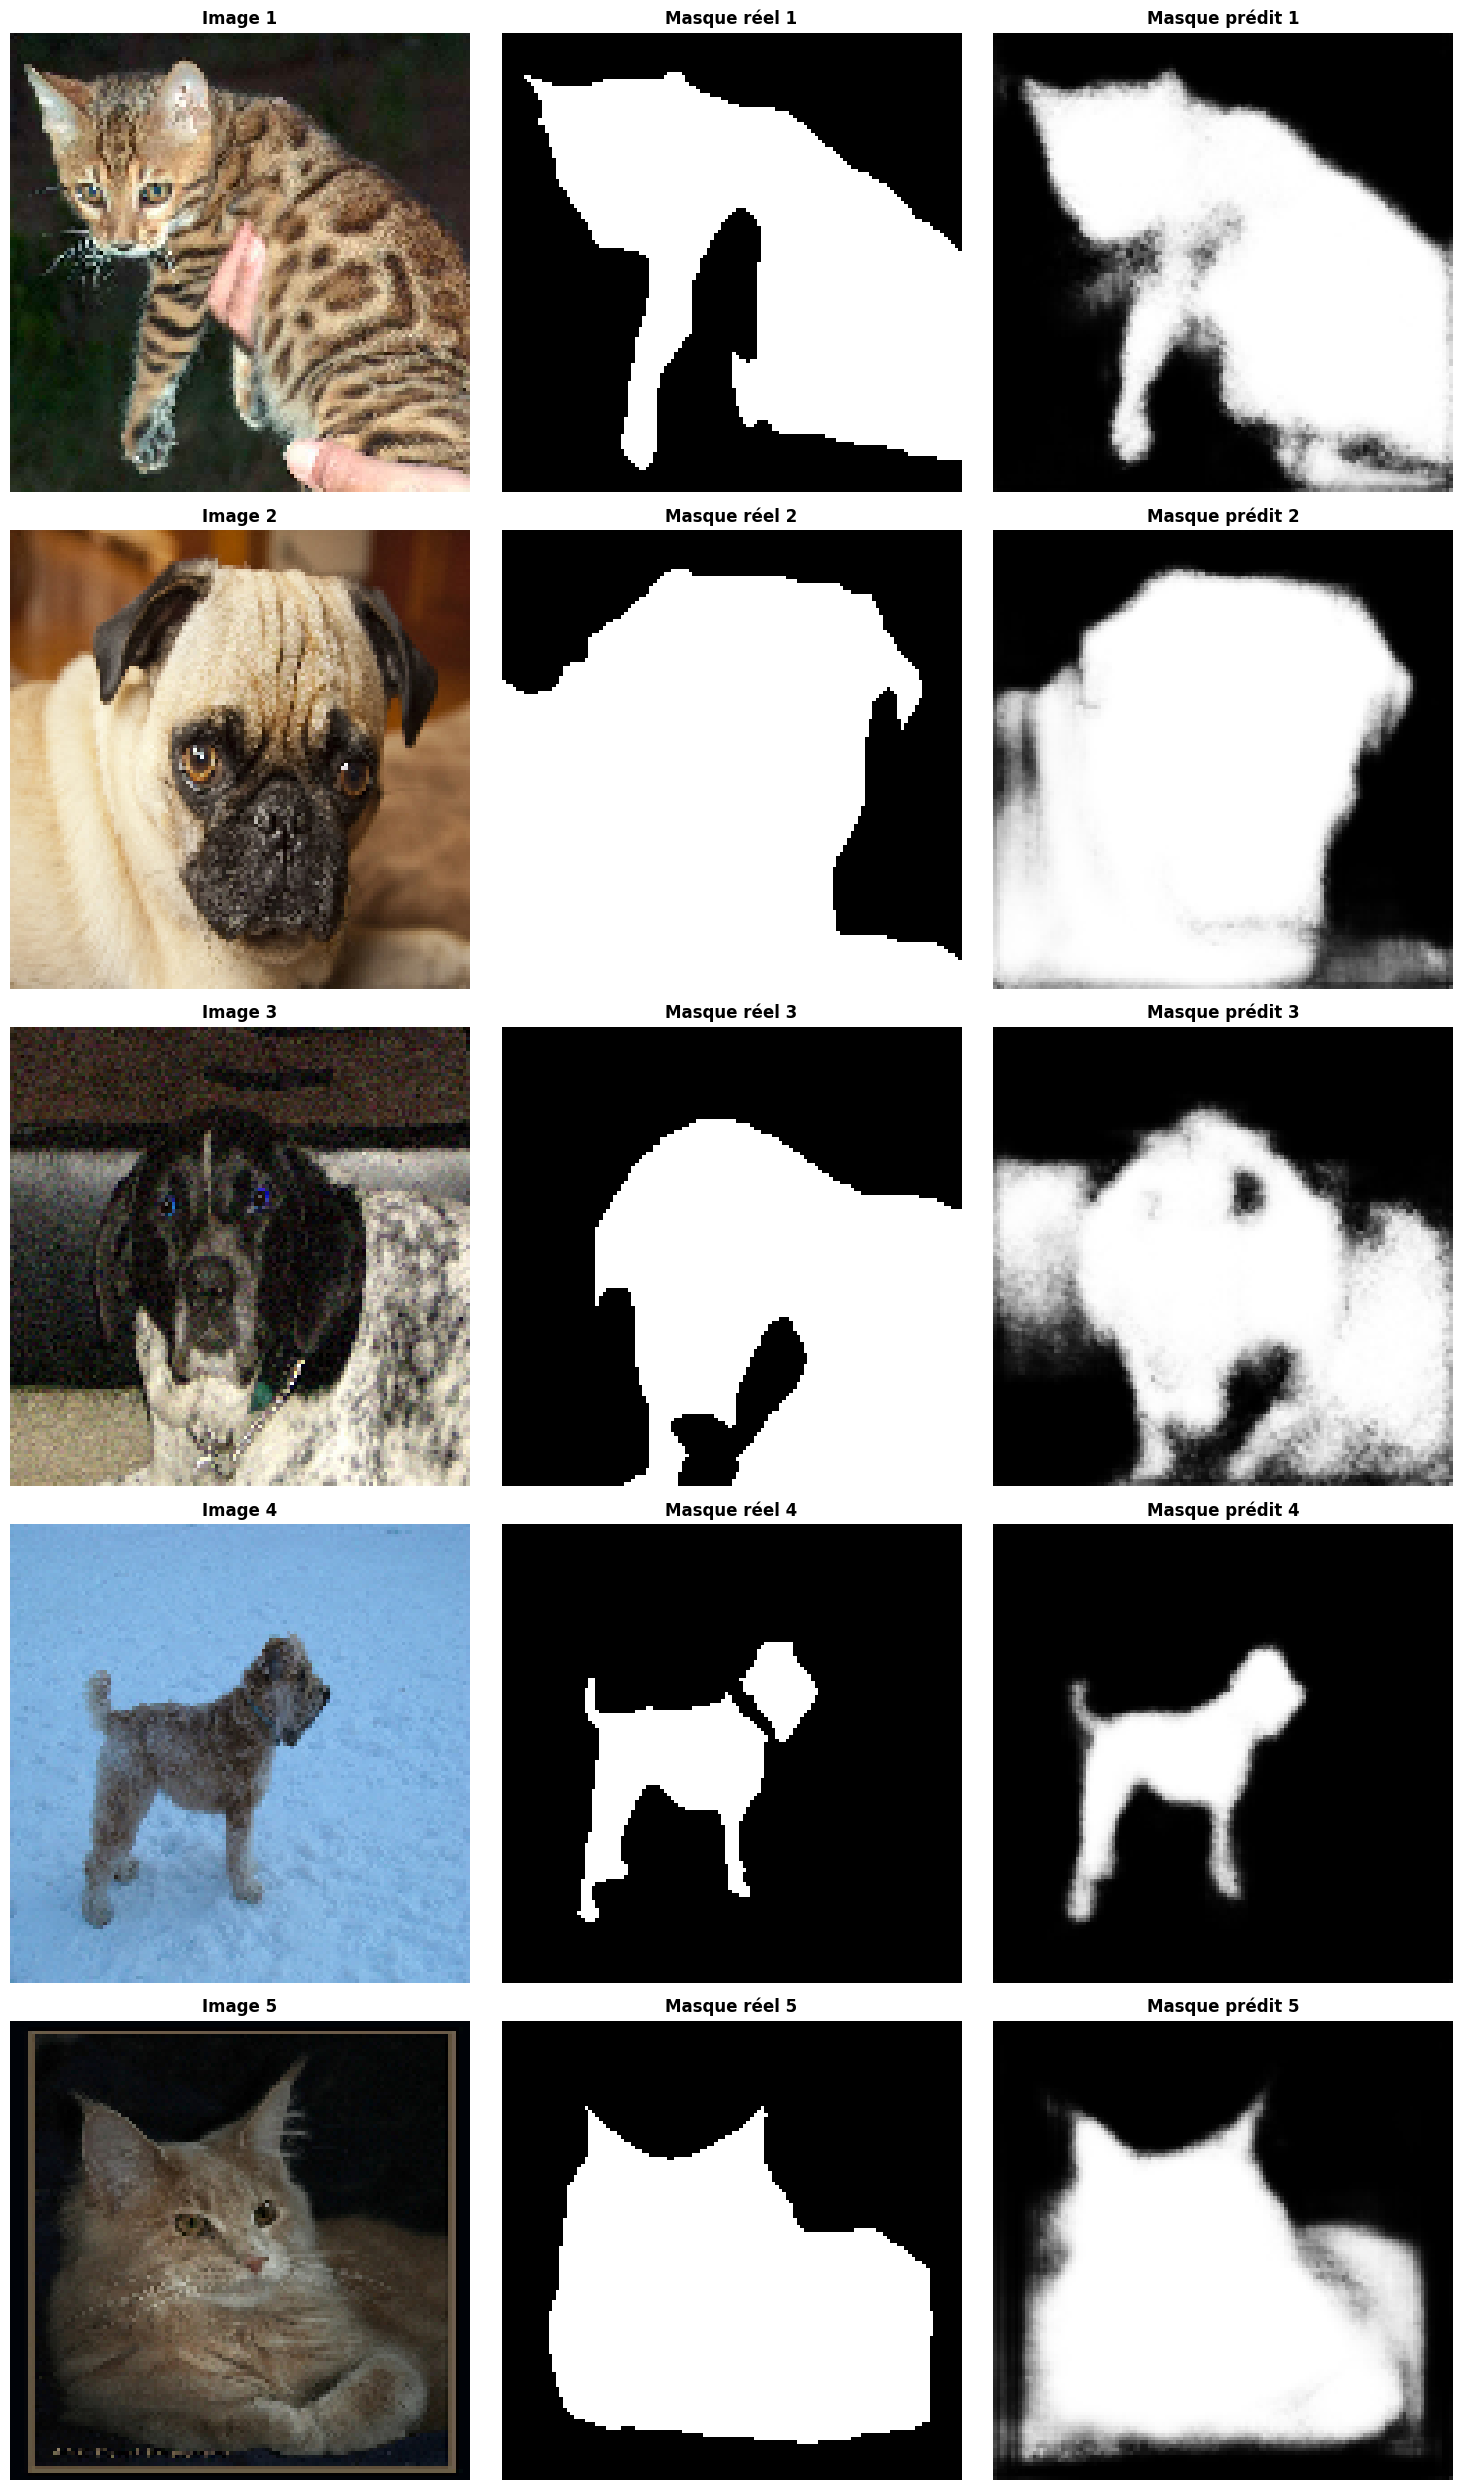

In [49]:
Visualisation_Prediction_U_Net(Unet,val_loader_seg,num_examples=5)

On va analyser la qualité de la segmentation en utilisant des métriques adaptées comme le score DICE ou la métrique IoU :
- DICE score : Le score DICE mesure le ratio entre 2 fois l'intersection entre la segmentation proposée par le modèle et la ground truth et la somme des aires des chaque segmentation.
- IoU : L'IoU mesure le rapport entre l'intersection de la segmentation proposée par le modèle et le ground truth et l'union entre entre les 2. l'IoU se mesure entre 0 et 1, 1 étant le cas ou les 2 segmentations sont identiques.
- La précision mesure la quantité de pixels prédits comme appartenant à l'animal qui y appartiennetn réellement
- le recall mesure la quantité de de vrais pixels d'animaux qui sont correctement prédits pas le réseau

In [50]:
Segmentation_Scores(val_loader_seg,Unet)

MÉTRIQUES DE SEGMENTATION 

Accuracy pixel-wise:  0.9502 (défaut)
IoU (Jaccard):        0.8437
Dice coefficient:     0.9152
Precision:   0.9164
Recall:      0.9140


Interprétation :

L'IoU et le DICE score proches de 1 indiquent un très bon overlap entre la segmenattion prédite par le Unet et la ground truth.

La précision de 0.9164 indique que 91.6% des pixels prédits comme étant des animaux le sont véritablement. 

Le recall de 0.9140 indique lui que 91.4% des vrais pixels d'animaux sont détectés.

Ces résultats confirment que le Unet réussit bien la tâche de segmentation des animaux

## 5- Analyse comparative

In [54]:
import numpy as np
import pandas as pd
import tensorflow as tf
import os
from tensorflow.keras.preprocessing.image import load_img, img_to_array

df_results = comparaison_races (Unet,img_dir,mask_dir,validation_df_seg,df)


 CHATS vs CHIENS (IoU Moyen)
  SPECIES_NAME       IoU
0          Cat  0.843742
1          Dog  0.816141

 Classement races par qualité de segmentation (IoU)

 10 races les mieux segmentées
       BREED_NAME      IoU
British_Shorthair 0.921439
          Ragdoll 0.896830
     newfoundland 0.891111
           Bombay 0.889581
         keeshond 0.883865
     Russian_Blue 0.876955
       leonberger 0.869079
       pomeranian 0.861659
         havanese 0.860591
              pug 0.850535

 10 races les moins bien segmentées
               BREED_NAME      IoU
                   Bengal 0.800810
          wheaten_terrier 0.796362
           english_setter 0.795911
american_pit_bull_terrier 0.784173
         american_bulldog 0.781687
                    boxer 0.780510
                   beagle 0.761008
                   Sphynx 0.742370
       miniature_pinscher 0.736615
       german_shorthaired 0.735534


Les performances pour les Chats et les Chiens sont très similaires avec un léger avantage pour les Chats. 

On va maintenant regarder plus en détail les races les mieux et les moins bien segmentées pour essayer de comprendre quelles sont les différences


Visualisation : Meilleures segmentations


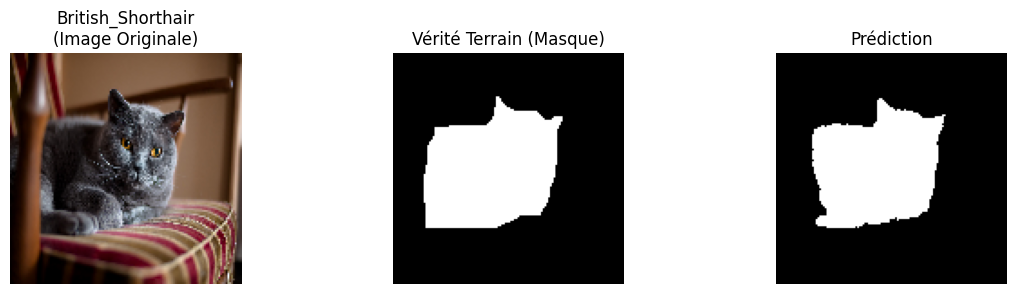

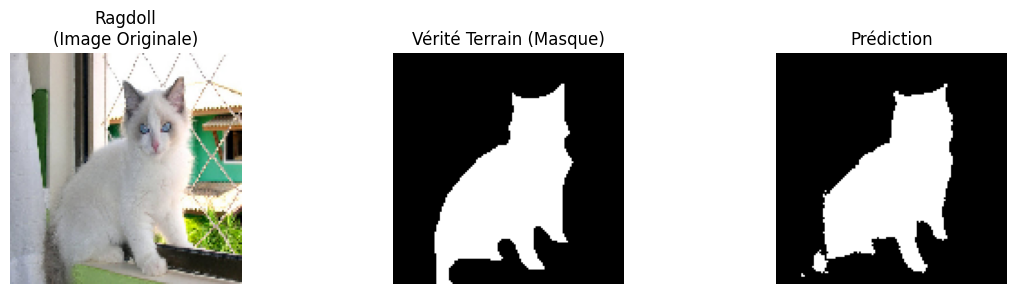

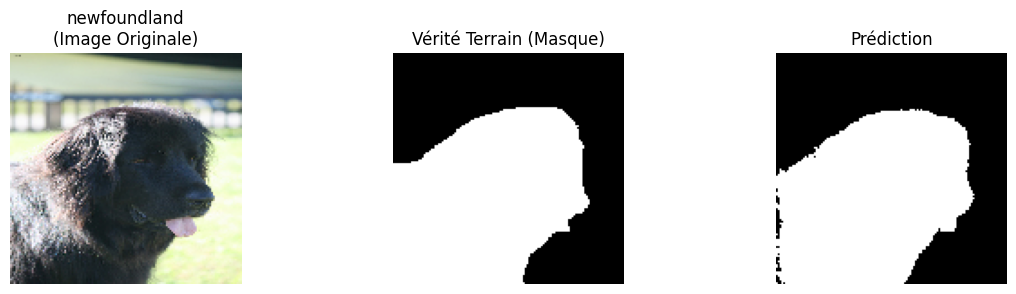

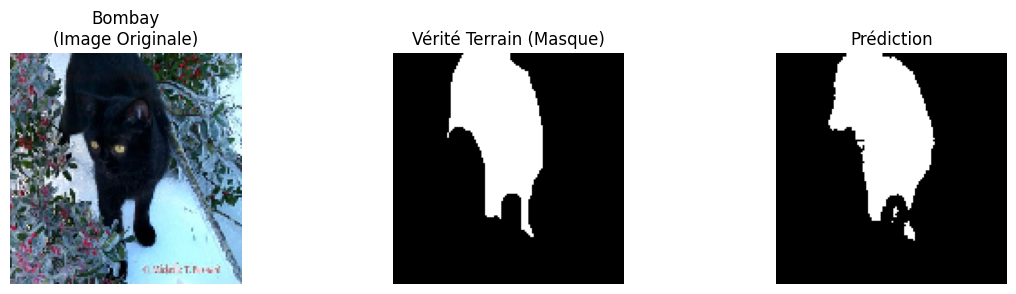

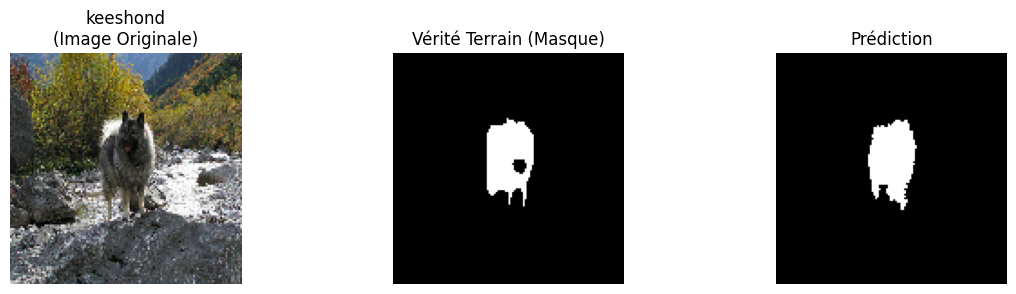


Visualisation : Pires segmenattions


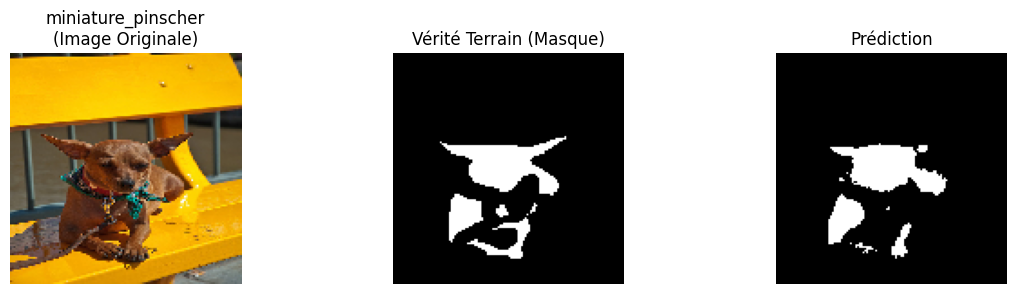

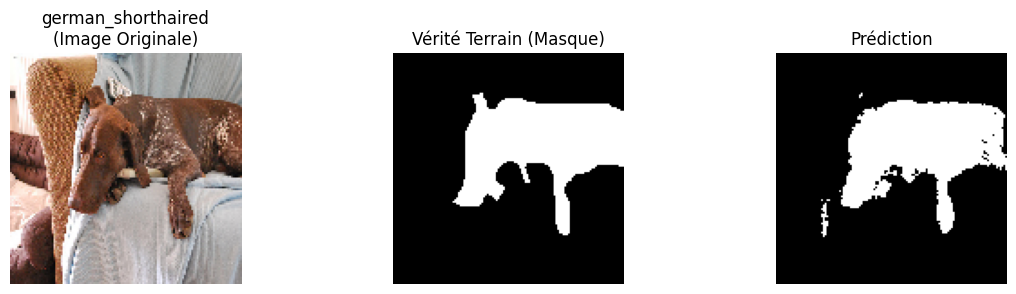

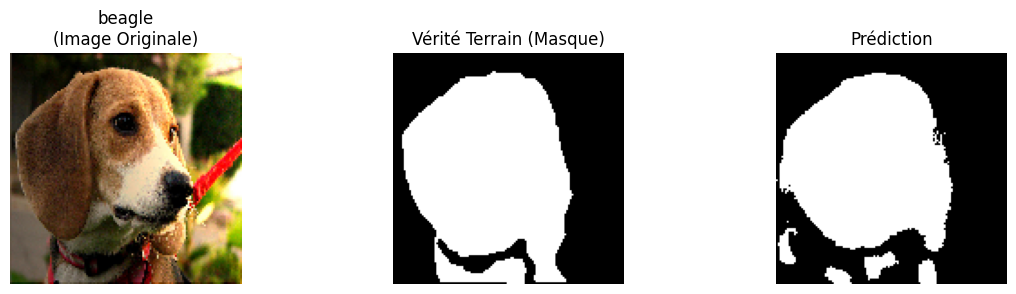

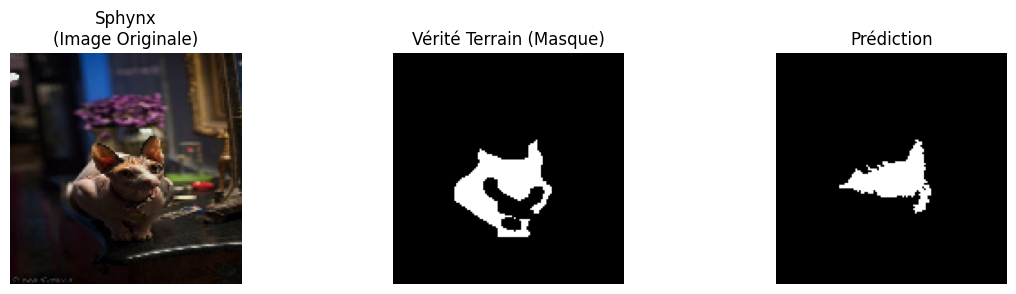

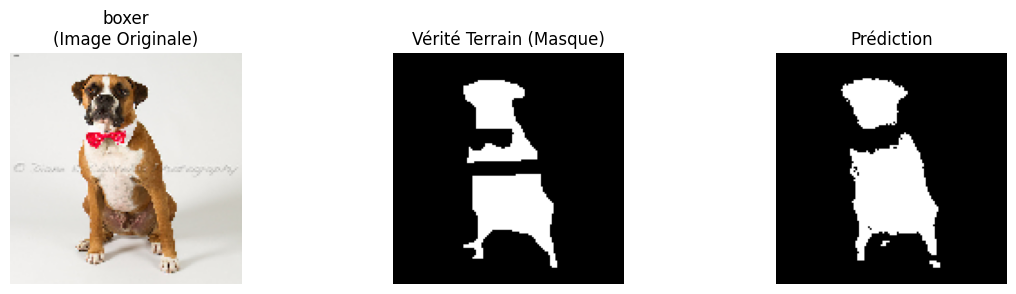

In [55]:
import matplotlib.pyplot as plt
import numpy as np
import os
from tensorflow.keras.preprocessing.image import load_img, img_to_array

best5 = ["British_Shorthair", "Ragdoll", "newfoundland", "Bombay", "keeshond"]
worst5 = ["miniature_pinscher", "german_shorthaired", "beagle", "Sphynx", "boxer"]

IMG_DIR = "./oxford-iiit-pet/images/" 
MASK_DIR = "./oxford-iiit-pet/annotations/trimaps"

visualize_specific_breeds(best5, df_results, Unet, IMG_DIR, MASK_DIR, "Meilleures segmentations")
visualize_specific_breeds(worst5, df_results, Unet, IMG_DIR, MASK_DIR, "Pires segmenattions")

Les races avec de moins bons scores semblent être des races ou il y a souvent des colliers sur les images, ou les images sont plutôt en extérieur et où le pelage des animaux n'est pas uni et assez proche du fond.